<a href="https://colab.research.google.com/github/JoshuoYang/Big_data_P05_NYC-Open-Parking-And-Camera-Violations/blob/main/github_Big_Data_Model_0522_FineAmount_Pic_Test2020%2622.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [ ]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jre-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import countDistinct, when, udf
import pyspark.sql.functions as F
import pyspark
from datetime import datetime
from calendar import monthrange

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("project").getOrCreate()
sparkcontext = spark.sparkContext

# Data transformer

 one hot encoding

## Read data_Data_V4

In [ ]:
# path0 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_2019.csv'
path1 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Data2_merged_filled_2019_V4.csv'
path2 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Data2_merged_filled_2020_V4.csv'
path3 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Data2_merged_filled_2021_V4.csv'
path4 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Data2_merged_filled_2022_V4.csv'


# data
# data_0 = spark.read.csv(path0, header=True, inferSchema=True)
df_01 = pd.read_csv(path1, thousands=',', encoding='latin1')
df_02 = pd.read_csv(path2, thousands=',', encoding='latin1')
df_03 = pd.read_csv(path3, thousands=',', encoding='latin1')
df_04 = pd.read_csv(path4, thousands=',', encoding='latin1')

In [ ]:
df_04

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2022-01-01,1,6,85.882353,17,6.26,55.0,26.5,9.0
1,1,Bronx,2022-01-01,2,6,75.416667,12,6.26,55.0,26.5,9.0
2,2,Bronx,2022-01-01,3,6,60.833333,6,6.26,55.0,26.5,9.0
3,3,Bronx,2022-01-01,4,6,85.714286,14,6.26,55.0,26.5,9.0
4,4,Bronx,2022-01-01,5,6,72.857143,7,6.26,55.0,26.5,9.0
...,...,...,...,...,...,...,...,...,...,...,...
10230,10230,Saratoga,2022-03-15,17,2,50.000000,53,9.17,60.5,26.5,29.1
10231,10231,Saratoga,2022-03-15,18,2,50.000000,43,9.17,60.5,26.5,29.1
10232,10232,Saratoga,2022-03-15,19,2,50.000000,29,9.17,60.5,26.5,29.1
10233,10233,Saratoga,2022-03-15,20,2,50.000000,21,9.17,60.5,26.5,29.1


### Distinct Checking

In [ ]:
# data
# df_0 = spark.read.csv(path0, header=True, inferSchema=True)
df_d1 = spark.read.csv(path1, header=True, inferSchema=True)
df_d2 = spark.read.csv(path2, header=True, inferSchema=True)
df_d3 = spark.read.csv(path3, header=True, inferSchema=True)
df_d4 = spark.read.csv(path4, header=True, inferSchema=True)

In [ ]:
data_nCounty_2019 = df_d1.select('County').distinct().collect()
data_nCounty_2019

[Row(County='Kings'),
 Row(County='Queens'),
 Row(County='Saratoga'),
 Row(County='NewYork'),
 Row(County='Richmond'),
 Row(County='Bronx')]

In [ ]:
data_nCounty_2020 = df_d2.select('County').distinct().collect()
data_nCounty_2020

[Row(County='Kings'),
 Row(County='Queens'),
 Row(County='Saratoga'),
 Row(County='Putnam'),
 Row(County='NewYork'),
 Row(County='Richmond'),
 Row(County='Bronx')]

In [ ]:
data_nCounty_2021 = df_d3.select('County').distinct().collect()
data_nCounty_2021

[Row(County='Kings'),
 Row(County='Queens'),
 Row(County='Albany'),
 Row(County='Fulton'),
 Row(County='Saratoga'),
 Row(County='NewYork'),
 Row(County='Richmond'),
 Row(County='Bronx')]

In [ ]:
data_nCounty_2022 = df_d4.select('County').distinct().collect()
data_nCounty_2022

[Row(County='Kings'),
 Row(County='Queens'),
 Row(County='Saratoga'),
 Row(County='NewYork'),
 Row(County='Richmond'),
 Row(County='Bronx')]

## Read data_Data_V4-3(Queens)


In [ ]:
# path0 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_2019.csv'
path01 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Queens_20192021.csv'
path02 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Queens_2020.csv'
path03 = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/01_Dataset/Data_for_use/Data_2_Violations_V4/Queens_2022.csv'

# data
# data_0 = spark.read.csv(path0, header=True, inferSchema=True)
df_q1 = pd.read_csv(path01, thousands=',', encoding='latin1')
df_q2 = pd.read_csv(path02, thousands=',', encoding='latin1')
df_q3 = pd.read_csv(path03, thousands=',', encoding='latin1')

In [ ]:
df_q1

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
0,0,Queens,2019-01-01,0,2,105.000000,5,17.00,55.5,25.5,23.0,1,1
1,1,Queens,2019-01-01,1,2,65.294118,17,17.00,55.5,25.5,23.0,1,1
2,2,Queens,2019-01-01,2,2,81.800000,25,17.00,55.5,25.5,23.0,1,1
3,3,Queens,2019-01-01,3,2,66.764706,17,17.00,55.5,25.5,23.0,1,1
4,4,Queens,2019-01-01,4,2,55.909091,11,17.00,55.5,25.5,23.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,17429,Queens,2021-11-02,11,2,57.056415,1099,7.61,54.5,27.0,23.0,11,2
17430,17430,Queens,2021-11-06,9,6,63.537634,465,5.14,51.5,24.5,13.0,11,6
17431,17431,Queens,2021-11-06,17,6,58.623596,178,5.14,51.5,24.5,13.0,11,6
17432,17432,Queens,2021-12-03,10,5,59.272085,1415,17.45,49.5,24.5,40.9,12,3


## df_1_Data V4(2019+2021)_one hot encoding (no weather)df_1_oh

In [ ]:
df_1921_c = [df_01, df_03]

df_1921 = pd.concat(df_1921_c)
df_1921.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2019-01-01,0,2,115.000000,1,17.0,55.5,25.5,23.0
1,1,Bronx,2019-01-01,1,2,106.538462,13,17.0,55.5,25.5,23.0
2,2,Bronx,2019-01-01,2,2,101.111111,18,17.0,55.5,25.5,23.0
3,3,Bronx,2019-01-01,3,2,77.500000,8,17.0,55.5,25.5,23.0
4,4,Bronx,2019-01-01,4,2,50.000000,3,17.0,55.5,25.5,23.0
5,5,Bronx,2019-01-01,5,2,65.000000,3,17.0,55.5,25.5,23.0
6,6,Bronx,2019-01-01,6,2,62.222222,9,17.0,55.5,25.5,23.0
7,7,Bronx,2019-01-01,7,2,50.000000,3,17.0,55.5,25.5,23.0
8,8,Bronx,2019-01-01,8,2,80.500000,10,17.0,55.5,25.5,23.0
9,9,Bronx,2019-01-01,9,2,85.625000,8,17.0,55.5,25.5,23.0


In [ ]:
df_1921.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
47507,47507,Saratoga,2021-10-07,1,4,50.0,1,4.03,73.5,34.5,14.10
47508,47508,Saratoga,2021-10-14,1,4,50.0,1,6.71,75.0,35.5,21.00
47509,47509,Saratoga,2021-10-24,3,7,50.0,5,6.71,58.5,28.0,16.10
47510,47510,Saratoga,2021-11-10,8,3,50.0,67,8.50,64.0,31.0,27.10
47511,47511,Saratoga,2021-11-13,21,6,50.0,3,13.20,59.5,27.5,52.10
47512,47512,Saratoga,2021-11-13,23,6,50.0,2,13.20,59.5,27.5,52.10
47513,47513,Saratoga,2021-12-08,6,3,50.0,41,9.17,41.5,20.0,14.05
47514,47514,Saratoga,2021-12-22,23,3,50.0,2,16.11,45.5,21.5,21.55
47515,47515,Saratoga,2021-12-23,16,4,50.0,76,14.09,36.0,17.5,31.10
47516,47516,Saratoga,2021-12-26,16,7,50.0,7,19.01,50.0,24.0,40.00


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1 = df_1921[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1 = df_1.dropna()
df_1.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
0,Bronx,2019-01-01,0,2,115.000000,1
1,Bronx,2019-01-01,1,2,106.538462,13
2,Bronx,2019-01-01,2,2,101.111111,18
3,Bronx,2019-01-01,3,2,77.500000,8
4,Bronx,2019-01-01,4,2,50.000000,3
5,Bronx,2019-01-01,5,2,65.000000,3
6,Bronx,2019-01-01,6,2,62.222222,9
7,Bronx,2019-01-01,7,2,50.000000,3
8,Bronx,2019-01-01,8,2,80.500000,10
9,Bronx,2019-01-01,9,2,85.625000,8


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_1.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Queens', 'Richmond', 'Saratoga',
       'Albany', 'Fulton'], dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_1 = [df_1, df_County]

df_1_new = pd.concat(frames_df_1)
df_1_new.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
47511,Saratoga,2021-11-13,21.0,6.0,50.0,3.0
47512,Saratoga,2021-11-13,23.0,6.0,50.0,2.0
47513,Saratoga,2021-12-08,6.0,3.0,50.0,41.0
47514,Saratoga,2021-12-22,23.0,3.0,50.0,2.0
47515,Saratoga,2021-12-23,16.0,4.0,50.0,76.0
47516,Saratoga,2021-12-26,16.0,7.0,50.0,7.0
0,Kings,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_1_new #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,Saratoga,2021-11-13,23.0,6.0,50.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,11,13
47513,Saratoga,2021-12-08,6.0,3.0,50.000000,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,08
47514,Saratoga,2021-12-22,23.0,3.0,50.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,22
47515,Saratoga,2021-12-23,16.0,4.0,50.000000,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,23


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_1_oh = df
df_1_oh

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,Saratoga,2021-11-13,23.0,6.0,50.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,11.0,13.0
47513,Saratoga,2021-12-08,6.0,3.0,50.000000,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,8.0
47514,Saratoga,2021-12-22,23.0,3.0,50.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,22.0
47515,Saratoga,2021-12-23,16.0,4.0,50.000000,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,23.0


### For test (2020+2022)_df_1_toh

In [ ]:
df_20_22_c = [df_02, df_04]

df_20_22 = pd.concat(df_20_22_c)
df_20_22.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2020-01-01,0,3,115.000000,1,15.88,41.0,20.0,32.0
1,1,Bronx,2020-01-01,1,3,66.000000,10,15.88,41.0,20.0,32.0
2,2,Bronx,2020-01-01,2,3,72.500000,2,15.88,41.0,20.0,32.0
3,3,Bronx,2020-01-01,3,3,93.461538,13,15.88,41.0,20.0,32.0
4,4,Bronx,2020-01-01,4,3,85.454545,11,15.88,41.0,20.0,32.0
5,5,Bronx,2020-01-01,5,3,115.000000,2,15.88,41.0,20.0,32.0
6,6,Bronx,2020-01-01,6,3,50.000000,3,15.88,41.0,20.0,32.0
7,7,Bronx,2020-01-01,8,3,93.333333,6,15.88,41.0,20.0,32.0
8,8,Bronx,2020-01-01,9,3,71.500000,10,15.88,41.0,20.0,32.0
9,9,Bronx,2020-01-01,10,3,50.000000,3,15.88,41.0,20.0,32.0


In [ ]:
df_20_22.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10225,10225,Saratoga,2022-03-15,12,2,50.0,42,9.17,60.5,26.5,29.1
10226,10226,Saratoga,2022-03-15,13,2,50.0,54,9.17,60.5,26.5,29.1
10227,10227,Saratoga,2022-03-15,14,2,50.0,47,9.17,60.5,26.5,29.1
10228,10228,Saratoga,2022-03-15,15,2,50.0,36,9.17,60.5,26.5,29.1
10229,10229,Saratoga,2022-03-15,16,2,50.0,53,9.17,60.5,26.5,29.1
10230,10230,Saratoga,2022-03-15,17,2,50.0,53,9.17,60.5,26.5,29.1
10231,10231,Saratoga,2022-03-15,18,2,50.0,43,9.17,60.5,26.5,29.1
10232,10232,Saratoga,2022-03-15,19,2,50.0,29,9.17,60.5,26.5,29.1
10233,10233,Saratoga,2022-03-15,20,2,50.0,21,9.17,60.5,26.5,29.1
10234,10234,Saratoga,2022-03-15,21,2,50.0,36,9.17,60.5,26.5,29.1


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1_t = df_20_22[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1_t = df_1_t.dropna()
df_1_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
0,Bronx,2020-01-01,0,3,115.000000,1
1,Bronx,2020-01-01,1,3,66.000000,10
2,Bronx,2020-01-01,2,3,72.500000,2
3,Bronx,2020-01-01,3,3,93.461538,13
4,Bronx,2020-01-01,4,3,85.454545,11
5,Bronx,2020-01-01,5,3,115.000000,2
6,Bronx,2020-01-01,6,3,50.000000,3
7,Bronx,2020-01-01,8,3,93.333333,6
8,Bronx,2020-01-01,9,3,71.500000,10
9,Bronx,2020-01-01,10,3,50.000000,3


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_1_t.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Putnam', 'Queens', 'Richmond',
       'Saratoga'], dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_1_t = [df_1_t, df_County]

df_1_tnew = pd.concat(frames_df_1_t)
df_1_tnew.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
10229,Saratoga,2022-03-15,16.0,2.0,50.0,53.0
10230,Saratoga,2022-03-15,17.0,2.0,50.0,53.0
10231,Saratoga,2022-03-15,18.0,2.0,50.0,43.0
10232,Saratoga,2022-03-15,19.0,2.0,50.0,29.0
10233,Saratoga,2022-03-15,20.0,2.0,50.0,21.0
10234,Saratoga,2022-03-15,21.0,2.0,50.0,36.0
0,Kings,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_1_tnew #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_1_toh = df
df_1_toh

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0


### For test (2022)_df_1_toh1

In [ ]:
# df_20_22_c = [df_02, df_04]

# df_20_22 = pd.concat(df_20_22_c)
df_20_22 = df_04
df_20_22.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2022-01-01,1,6,85.882353,17,6.26,55.0,26.5,9.0
1,1,Bronx,2022-01-01,2,6,75.416667,12,6.26,55.0,26.5,9.0
2,2,Bronx,2022-01-01,3,6,60.833333,6,6.26,55.0,26.5,9.0
3,3,Bronx,2022-01-01,4,6,85.714286,14,6.26,55.0,26.5,9.0
4,4,Bronx,2022-01-01,5,6,72.857143,7,6.26,55.0,26.5,9.0
5,5,Bronx,2022-01-01,6,6,68.333333,6,6.26,55.0,26.5,9.0
6,6,Bronx,2022-01-01,7,6,80.000000,3,6.26,55.0,26.5,9.0
7,7,Bronx,2022-01-01,8,6,93.750000,4,6.26,55.0,26.5,9.0
8,8,Bronx,2022-01-01,9,6,93.571429,14,6.26,55.0,26.5,9.0
9,9,Bronx,2022-01-01,10,6,93.000000,45,6.26,55.0,26.5,9.0


In [ ]:
df_20_22.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10225,10225,Saratoga,2022-03-15,12,2,50.0,42,9.17,60.5,26.5,29.1
10226,10226,Saratoga,2022-03-15,13,2,50.0,54,9.17,60.5,26.5,29.1
10227,10227,Saratoga,2022-03-15,14,2,50.0,47,9.17,60.5,26.5,29.1
10228,10228,Saratoga,2022-03-15,15,2,50.0,36,9.17,60.5,26.5,29.1
10229,10229,Saratoga,2022-03-15,16,2,50.0,53,9.17,60.5,26.5,29.1
10230,10230,Saratoga,2022-03-15,17,2,50.0,53,9.17,60.5,26.5,29.1
10231,10231,Saratoga,2022-03-15,18,2,50.0,43,9.17,60.5,26.5,29.1
10232,10232,Saratoga,2022-03-15,19,2,50.0,29,9.17,60.5,26.5,29.1
10233,10233,Saratoga,2022-03-15,20,2,50.0,21,9.17,60.5,26.5,29.1
10234,10234,Saratoga,2022-03-15,21,2,50.0,36,9.17,60.5,26.5,29.1


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1_t = df_20_22[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_1_t = df_1_t.dropna()
df_1_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
0,Bronx,2022-01-01,1,6,85.882353,17
1,Bronx,2022-01-01,2,6,75.416667,12
2,Bronx,2022-01-01,3,6,60.833333,6
3,Bronx,2022-01-01,4,6,85.714286,14
4,Bronx,2022-01-01,5,6,72.857143,7
5,Bronx,2022-01-01,6,6,68.333333,6
6,Bronx,2022-01-01,7,6,80.000000,3
7,Bronx,2022-01-01,8,6,93.750000,4
8,Bronx,2022-01-01,9,6,93.571429,14
9,Bronx,2022-01-01,10,6,93.000000,45


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_1_t.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Queens', 'Richmond', 'Saratoga'],
      dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_1_t = [df_1_t, df_County]

df_1_tnew = pd.concat(frames_df_1_t)
df_1_tnew.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation)
10229,Saratoga,2022-03-15,16.0,2.0,50.0,53.0
10230,Saratoga,2022-03-15,17.0,2.0,50.0,53.0
10231,Saratoga,2022-03-15,18.0,2.0,50.0,43.0
10232,Saratoga,2022-03-15,19.0,2.0,50.0,29.0
10233,Saratoga,2022-03-15,20.0,2.0,50.0,21.0
10234,Saratoga,2022-03-15,21.0,2.0,50.0,36.0
0,Kings,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_1_tnew #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_1_toh1 = df
df_1_toh1

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0


## df_2_Data V4(2019+2021)_one hot encoding (weather)df_2_oh

In [ ]:
df_1921_c = [df_01, df_03]

df_1921 = pd.concat(df_1921_c)
df_1921.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2019-01-01,0,2,115.000000,1,17.0,55.5,25.5,23.0
1,1,Bronx,2019-01-01,1,2,106.538462,13,17.0,55.5,25.5,23.0
2,2,Bronx,2019-01-01,2,2,101.111111,18,17.0,55.5,25.5,23.0
3,3,Bronx,2019-01-01,3,2,77.500000,8,17.0,55.5,25.5,23.0
4,4,Bronx,2019-01-01,4,2,50.000000,3,17.0,55.5,25.5,23.0
5,5,Bronx,2019-01-01,5,2,65.000000,3,17.0,55.5,25.5,23.0
6,6,Bronx,2019-01-01,6,2,62.222222,9,17.0,55.5,25.5,23.0
7,7,Bronx,2019-01-01,7,2,50.000000,3,17.0,55.5,25.5,23.0
8,8,Bronx,2019-01-01,8,2,80.500000,10,17.0,55.5,25.5,23.0
9,9,Bronx,2019-01-01,9,2,85.625000,8,17.0,55.5,25.5,23.0


In [ ]:
df_1921.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
47507,47507,Saratoga,2021-10-07,1,4,50.0,1,4.03,73.5,34.5,14.10
47508,47508,Saratoga,2021-10-14,1,4,50.0,1,6.71,75.0,35.5,21.00
47509,47509,Saratoga,2021-10-24,3,7,50.0,5,6.71,58.5,28.0,16.10
47510,47510,Saratoga,2021-11-10,8,3,50.0,67,8.50,64.0,31.0,27.10
47511,47511,Saratoga,2021-11-13,21,6,50.0,3,13.20,59.5,27.5,52.10
47512,47512,Saratoga,2021-11-13,23,6,50.0,2,13.20,59.5,27.5,52.10
47513,47513,Saratoga,2021-12-08,6,3,50.0,41,9.17,41.5,20.0,14.05
47514,47514,Saratoga,2021-12-22,23,3,50.0,2,16.11,45.5,21.5,21.55
47515,47515,Saratoga,2021-12-23,16,4,50.0,76,14.09,36.0,17.5,31.10
47516,47516,Saratoga,2021-12-26,16,7,50.0,7,19.01,50.0,24.0,40.00


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_2 = df_1921[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_2 = df_2.dropna()
df_2.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Bronx,2019-01-01,0,2,115.000000,1,17.0,55.5,25.5,23.0
1,Bronx,2019-01-01,1,2,106.538462,13,17.0,55.5,25.5,23.0
2,Bronx,2019-01-01,2,2,101.111111,18,17.0,55.5,25.5,23.0
3,Bronx,2019-01-01,3,2,77.500000,8,17.0,55.5,25.5,23.0
4,Bronx,2019-01-01,4,2,50.000000,3,17.0,55.5,25.5,23.0
5,Bronx,2019-01-01,5,2,65.000000,3,17.0,55.5,25.5,23.0
6,Bronx,2019-01-01,6,2,62.222222,9,17.0,55.5,25.5,23.0
7,Bronx,2019-01-01,7,2,50.000000,3,17.0,55.5,25.5,23.0
8,Bronx,2019-01-01,8,2,80.500000,10,17.0,55.5,25.5,23.0
9,Bronx,2019-01-01,9,2,85.625000,8,17.0,55.5,25.5,23.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_2.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Queens', 'Richmond', 'Saratoga',
       'Albany', 'Fulton'], dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_2 = [df_2, df_County]

df_2_new = pd.concat(frames_df_2)
df_2_new.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
47511,Saratoga,2021-11-13,21.0,6.0,50.0,3.0,13.20,59.5,27.5,52.10
47512,Saratoga,2021-11-13,23.0,6.0,50.0,2.0,13.20,59.5,27.5,52.10
47513,Saratoga,2021-12-08,6.0,3.0,50.0,41.0,9.17,41.5,20.0,14.05
47514,Saratoga,2021-12-22,23.0,3.0,50.0,2.0,16.11,45.5,21.5,21.55
47515,Saratoga,2021-12-23,16.0,4.0,50.0,76.0,14.09,36.0,17.5,31.10
47516,Saratoga,2021-12-26,16.0,7.0,50.0,7.0,19.01,50.0,24.0,40.00
0,Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_2_new #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,17.0,55.5,25.5,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,17.0,55.5,25.5,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,17.0,55.5,25.5,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,17.0,55.5,25.5,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,17.0,55.5,25.5,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,17.0,55.5,25.5,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,17.0,55.5,25.5,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,17.0,55.5,25.5,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,17.0,55.5,25.5,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,17.0,55.5,25.5,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,Saratoga,2021-11-13,23.0,6.0,50.000000,2.0,13.20,59.5,27.5,52.10,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,11,13
47513,Saratoga,2021-12-08,6.0,3.0,50.000000,41.0,9.17,41.5,20.0,14.05,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,08
47514,Saratoga,2021-12-22,23.0,3.0,50.000000,2.0,16.11,45.5,21.5,21.55,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,22
47515,Saratoga,2021-12-23,16.0,4.0,50.000000,76.0,14.09,36.0,17.5,31.10,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12,23


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_2_oh = df
df_2_oh

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2019-01-01,0.0,2.0,115.000000,1.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
1,Bronx,2019-01-01,1.0,2.0,106.538462,13.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
2,Bronx,2019-01-01,2.0,2.0,101.111111,18.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
3,Bronx,2019-01-01,3.0,2.0,77.500000,8.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
4,Bronx,2019-01-01,4.0,2.0,50.000000,3.0,17.00,55.5,25.5,23.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,Saratoga,2021-11-13,23.0,6.0,50.000000,2.0,13.20,59.5,27.5,52.10,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,11.0,13.0
47513,Saratoga,2021-12-08,6.0,3.0,50.000000,41.0,9.17,41.5,20.0,14.05,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,8.0
47514,Saratoga,2021-12-22,23.0,3.0,50.000000,2.0,16.11,45.5,21.5,21.55,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,22.0
47515,Saratoga,2021-12-23,16.0,4.0,50.000000,76.0,14.09,36.0,17.5,31.10,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2021,12.0,23.0


### For test (2020+2022)_df_2_toh

In [ ]:
df_20_22_c = [df_02, df_04]

df_20_22 = pd.concat(df_20_22_c)
df_20_22.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2020-01-01,0,3,115.000000,1,15.88,41.0,20.0,32.0
1,1,Bronx,2020-01-01,1,3,66.000000,10,15.88,41.0,20.0,32.0
2,2,Bronx,2020-01-01,2,3,72.500000,2,15.88,41.0,20.0,32.0
3,3,Bronx,2020-01-01,3,3,93.461538,13,15.88,41.0,20.0,32.0
4,4,Bronx,2020-01-01,4,3,85.454545,11,15.88,41.0,20.0,32.0
5,5,Bronx,2020-01-01,5,3,115.000000,2,15.88,41.0,20.0,32.0
6,6,Bronx,2020-01-01,6,3,50.000000,3,15.88,41.0,20.0,32.0
7,7,Bronx,2020-01-01,8,3,93.333333,6,15.88,41.0,20.0,32.0
8,8,Bronx,2020-01-01,9,3,71.500000,10,15.88,41.0,20.0,32.0
9,9,Bronx,2020-01-01,10,3,50.000000,3,15.88,41.0,20.0,32.0


In [ ]:
df_20_22.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10225,10225,Saratoga,2022-03-15,12,2,50.0,42,9.17,60.5,26.5,29.1
10226,10226,Saratoga,2022-03-15,13,2,50.0,54,9.17,60.5,26.5,29.1
10227,10227,Saratoga,2022-03-15,14,2,50.0,47,9.17,60.5,26.5,29.1
10228,10228,Saratoga,2022-03-15,15,2,50.0,36,9.17,60.5,26.5,29.1
10229,10229,Saratoga,2022-03-15,16,2,50.0,53,9.17,60.5,26.5,29.1
10230,10230,Saratoga,2022-03-15,17,2,50.0,53,9.17,60.5,26.5,29.1
10231,10231,Saratoga,2022-03-15,18,2,50.0,43,9.17,60.5,26.5,29.1
10232,10232,Saratoga,2022-03-15,19,2,50.0,29,9.17,60.5,26.5,29.1
10233,10233,Saratoga,2022-03-15,20,2,50.0,21,9.17,60.5,26.5,29.1
10234,10234,Saratoga,2022-03-15,21,2,50.0,36,9.17,60.5,26.5,29.1


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_2_t = df_20_22[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_2_t = df_2_t.dropna()
df_2_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Bronx,2020-01-01,0,3,115.000000,1,15.88,41.0,20.0,32.0
1,Bronx,2020-01-01,1,3,66.000000,10,15.88,41.0,20.0,32.0
2,Bronx,2020-01-01,2,3,72.500000,2,15.88,41.0,20.0,32.0
3,Bronx,2020-01-01,3,3,93.461538,13,15.88,41.0,20.0,32.0
4,Bronx,2020-01-01,4,3,85.454545,11,15.88,41.0,20.0,32.0
5,Bronx,2020-01-01,5,3,115.000000,2,15.88,41.0,20.0,32.0
6,Bronx,2020-01-01,6,3,50.000000,3,15.88,41.0,20.0,32.0
7,Bronx,2020-01-01,8,3,93.333333,6,15.88,41.0,20.0,32.0
8,Bronx,2020-01-01,9,3,71.500000,10,15.88,41.0,20.0,32.0
9,Bronx,2020-01-01,10,3,50.000000,3,15.88,41.0,20.0,32.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_2_t.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Putnam', 'Queens', 'Richmond',
       'Saratoga'], dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_2_t = [df_2_t, df_County]

df_2_tnew = pd.concat(frames_df_2_t)
df_2_tnew.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10229,Saratoga,2022-03-15,16.0,2.0,50.0,53.0,9.17,60.5,26.5,29.1
10230,Saratoga,2022-03-15,17.0,2.0,50.0,53.0,9.17,60.5,26.5,29.1
10231,Saratoga,2022-03-15,18.0,2.0,50.0,43.0,9.17,60.5,26.5,29.1
10232,Saratoga,2022-03-15,19.0,2.0,50.0,29.0,9.17,60.5,26.5,29.1
10233,Saratoga,2022-03-15,20.0,2.0,50.0,21.0,9.17,60.5,26.5,29.1
10234,Saratoga,2022-03-15,21.0,2.0,50.0,36.0,9.17,60.5,26.5,29.1
0,Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_2_tnew #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_2_toh = df
df_2_toh

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0


### For test (2022)_df_2_toh1

In [ ]:
# df_20_22_c = [df_02, df_04]

# df_20_22 = pd.concat(df_20_22_c)
df_20_22 = df_04
df_20_22.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,0,Bronx,2022-01-01,1,6,85.882353,17,6.26,55.0,26.5,9.0
1,1,Bronx,2022-01-01,2,6,75.416667,12,6.26,55.0,26.5,9.0
2,2,Bronx,2022-01-01,3,6,60.833333,6,6.26,55.0,26.5,9.0
3,3,Bronx,2022-01-01,4,6,85.714286,14,6.26,55.0,26.5,9.0
4,4,Bronx,2022-01-01,5,6,72.857143,7,6.26,55.0,26.5,9.0
5,5,Bronx,2022-01-01,6,6,68.333333,6,6.26,55.0,26.5,9.0
6,6,Bronx,2022-01-01,7,6,80.000000,3,6.26,55.0,26.5,9.0
7,7,Bronx,2022-01-01,8,6,93.750000,4,6.26,55.0,26.5,9.0
8,8,Bronx,2022-01-01,9,6,93.571429,14,6.26,55.0,26.5,9.0
9,9,Bronx,2022-01-01,10,6,93.000000,45,6.26,55.0,26.5,9.0


In [ ]:
df_20_22.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10225,10225,Saratoga,2022-03-15,12,2,50.0,42,9.17,60.5,26.5,29.1
10226,10226,Saratoga,2022-03-15,13,2,50.0,54,9.17,60.5,26.5,29.1
10227,10227,Saratoga,2022-03-15,14,2,50.0,47,9.17,60.5,26.5,29.1
10228,10228,Saratoga,2022-03-15,15,2,50.0,36,9.17,60.5,26.5,29.1
10229,10229,Saratoga,2022-03-15,16,2,50.0,53,9.17,60.5,26.5,29.1
10230,10230,Saratoga,2022-03-15,17,2,50.0,53,9.17,60.5,26.5,29.1
10231,10231,Saratoga,2022-03-15,18,2,50.0,43,9.17,60.5,26.5,29.1
10232,10232,Saratoga,2022-03-15,19,2,50.0,29,9.17,60.5,26.5,29.1
10233,10233,Saratoga,2022-03-15,20,2,50.0,21,9.17,60.5,26.5,29.1
10234,10234,Saratoga,2022-03-15,21,2,50.0,36,9.17,60.5,26.5,29.1


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_2_t = df_20_22[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_2_t = df_2_t.dropna()
df_2_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Bronx,2022-01-01,1,6,85.882353,17,6.26,55.0,26.5,9.0
1,Bronx,2022-01-01,2,6,75.416667,12,6.26,55.0,26.5,9.0
2,Bronx,2022-01-01,3,6,60.833333,6,6.26,55.0,26.5,9.0
3,Bronx,2022-01-01,4,6,85.714286,14,6.26,55.0,26.5,9.0
4,Bronx,2022-01-01,5,6,72.857143,7,6.26,55.0,26.5,9.0
5,Bronx,2022-01-01,6,6,68.333333,6,6.26,55.0,26.5,9.0
6,Bronx,2022-01-01,7,6,80.000000,3,6.26,55.0,26.5,9.0
7,Bronx,2022-01-01,8,6,93.750000,4,6.26,55.0,26.5,9.0
8,Bronx,2022-01-01,9,6,93.571429,14,6.26,55.0,26.5,9.0
9,Bronx,2022-01-01,10,6,93.000000,45,6.26,55.0,26.5,9.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    # dtype=<class 'numpy.float64'>, # Desired data type of the output
    handle_unknown='error' # Whether to raise an error
)

OneHotEncoder()

In [ ]:
df_2_t.County.unique()

array(['Bronx', 'Kings', 'NewYork', 'Queens', 'Richmond', 'Saratoga'],
      dtype=object)

In [ ]:
d = {'County': ['Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam']}
df_County = pd.DataFrame(data=d)
df_County

,County
0,Kings
1,Queens
2,Bronx
3,Richmond
4,NewYork
5,Saratoga
6,Albany
7,Fulton
8,Putnam


In [ ]:
frames_df_2_t = [df_2_t, df_County]

df_2_tnew = pd.concat(frames_df_2_t)
df_2_tnew.tail(15)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
10229,Saratoga,2022-03-15,16.0,2.0,50.0,53.0,9.17,60.5,26.5,29.1
10230,Saratoga,2022-03-15,17.0,2.0,50.0,53.0,9.17,60.5,26.5,29.1
10231,Saratoga,2022-03-15,18.0,2.0,50.0,43.0,9.17,60.5,26.5,29.1
10232,Saratoga,2022-03-15,19.0,2.0,50.0,29.0,9.17,60.5,26.5,29.1
10233,Saratoga,2022-03-15,20.0,2.0,50.0,21.0,9.17,60.5,26.5,29.1
10234,Saratoga,2022-03-15,21.0,2.0,50.0,36.0,9.17,60.5,26.5,29.1
0,Kings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Richmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = df_2_tnew #load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['County']])
print(transformed.toarray())

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(ohe.categories_)

[array(['Albany', 'Bronx', 'Fulton', 'Kings', 'NewYork', 'Putnam',
       'Queens', 'Richmond', 'Saratoga'], dtype=object)]


In [ ]:
df[ohe.categories_[0]] = transformed.toarray()
df.head()

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,6.26,55.0,26.5,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,6.26,55.0,26.5,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,6.26,55.0,26.5,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,6.26,55.0,26.5,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,6.26,55.0,26.5,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['year'], df['month'], df['day'] = df['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NewYork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,Saratoga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
6,Albany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,Fulton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,03,15


In [ ]:
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

County               object
DATE                 object
Violation_Hour      float64
Issue_Weekday       float64
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
Albany              float64
Bronx               float64
Fulton              float64
Kings               float64
NewYork             float64
Putnam              float64
Queens              float64
Richmond            float64
Saratoga            float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_2_toh1 = df
df_2_toh1

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0


## df_3_Data V4(2019+2021)(Queens)df_3

In [ ]:
df_q1

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
0,0,Queens,2019-01-01,0,2,105.000000,5,17.00,55.5,25.5,23.0,1,1
1,1,Queens,2019-01-01,1,2,65.294118,17,17.00,55.5,25.5,23.0,1,1
2,2,Queens,2019-01-01,2,2,81.800000,25,17.00,55.5,25.5,23.0,1,1
3,3,Queens,2019-01-01,3,2,66.764706,17,17.00,55.5,25.5,23.0,1,1
4,4,Queens,2019-01-01,4,2,55.909091,11,17.00,55.5,25.5,23.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,17429,Queens,2021-11-02,11,2,57.056415,1099,7.61,54.5,27.0,23.0,11,2
17430,17430,Queens,2021-11-06,9,6,63.537634,465,5.14,51.5,24.5,13.0,11,6
17431,17431,Queens,2021-11-06,17,6,58.623596,178,5.14,51.5,24.5,13.0,11,6
17432,17432,Queens,2021-12-03,10,5,59.272085,1415,17.45,49.5,24.5,40.9,12,3


In [ ]:
df_1921_q = df_q1
df_1921_q.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
0,0,Queens,2019-01-01,0,2,105.000000,5,17.0,55.5,25.5,23.0,1,1
1,1,Queens,2019-01-01,1,2,65.294118,17,17.0,55.5,25.5,23.0,1,1
2,2,Queens,2019-01-01,2,2,81.800000,25,17.0,55.5,25.5,23.0,1,1
3,3,Queens,2019-01-01,3,2,66.764706,17,17.0,55.5,25.5,23.0,1,1
4,4,Queens,2019-01-01,4,2,55.909091,11,17.0,55.5,25.5,23.0,1,1
5,5,Queens,2019-01-01,5,2,55.000000,9,17.0,55.5,25.5,23.0,1,1
6,6,Queens,2019-01-01,6,2,53.333333,6,17.0,55.5,25.5,23.0,1,1
7,7,Queens,2019-01-01,7,2,64.318182,22,17.0,55.5,25.5,23.0,1,1
8,8,Queens,2019-01-01,8,2,59.333333,15,17.0,55.5,25.5,23.0,1,1
9,9,Queens,2019-01-01,9,2,77.894737,19,17.0,55.5,25.5,23.0,1,1


In [ ]:
df_1921_q.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
17424,17424,Queens,2021-09-05,20,7,80.641026,117,9.62,74.5,36.5,12.0,9,5
17425,17425,Queens,2021-10-03,3,7,72.826087,23,5.59,76.5,36.0,15.0,10,3
17426,17426,Queens,2021-10-11,10,1,53.527094,1015,12.97,70.0,33.5,30.0,10,11
17427,17427,Queens,2021-10-11,18,1,52.366483,543,12.97,70.0,33.5,30.0,10,11
17428,17428,Queens,2021-10-25,0,1,101.000000,5,8.50,70.0,32.5,14.5,10,25
17429,17429,Queens,2021-11-02,11,2,57.056415,1099,7.61,54.5,27.0,23.0,11,2
17430,17430,Queens,2021-11-06,9,6,63.537634,465,5.14,51.5,24.5,13.0,11,6
17431,17431,Queens,2021-11-06,17,6,58.623596,178,5.14,51.5,24.5,13.0,11,6
17432,17432,Queens,2021-12-03,10,5,59.272085,1415,17.45,49.5,24.5,40.9,12,3
17433,17433,Queens,2021-12-03,14,5,57.889259,1201,17.45,49.5,24.5,40.9,12,3


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_3 = df_1921_q[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_3 = df_3.dropna()
df_3.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Queens,2019-01-01,0,2,105.000000,5,17.0,55.5,25.5,23.0
1,Queens,2019-01-01,1,2,65.294118,17,17.0,55.5,25.5,23.0
2,Queens,2019-01-01,2,2,81.800000,25,17.0,55.5,25.5,23.0
3,Queens,2019-01-01,3,2,66.764706,17,17.0,55.5,25.5,23.0
4,Queens,2019-01-01,4,2,55.909091,11,17.0,55.5,25.5,23.0
5,Queens,2019-01-01,5,2,55.000000,9,17.0,55.5,25.5,23.0
6,Queens,2019-01-01,6,2,53.333333,6,17.0,55.5,25.5,23.0
7,Queens,2019-01-01,7,2,64.318182,22,17.0,55.5,25.5,23.0
8,Queens,2019-01-01,8,2,59.333333,15,17.0,55.5,25.5,23.0
9,Queens,2019-01-01,9,2,77.894737,19,17.0,55.5,25.5,23.0


In [ ]:
df_3.County.unique()

array(['Queens'], dtype=object)

In [ ]:
df_3['year'], df_3['month'], df_3['day'] = df_3['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df_3 = df_3.dropna()
df_3

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2019-01-01,0,2,105.000000,5,17.00,55.5,25.5,23.0,2019,01,01
1,Queens,2019-01-01,1,2,65.294118,17,17.00,55.5,25.5,23.0,2019,01,01
2,Queens,2019-01-01,2,2,81.800000,25,17.00,55.5,25.5,23.0,2019,01,01
3,Queens,2019-01-01,3,2,66.764706,17,17.00,55.5,25.5,23.0,2019,01,01
4,Queens,2019-01-01,4,2,55.909091,11,17.00,55.5,25.5,23.0,2019,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Queens,2021-11-02,11,2,57.056415,1099,7.61,54.5,27.0,23.0,2021,11,02
17430,Queens,2021-11-06,9,6,63.537634,465,5.14,51.5,24.5,13.0,2021,11,06
17431,Queens,2021-11-06,17,6,58.623596,178,5.14,51.5,24.5,13.0,2021,11,06
17432,Queens,2021-12-03,10,5,59.272085,1415,17.45,49.5,24.5,40.9,2021,12,03


In [ ]:
df = df_3
df["Violation_Hour"] = pd.to_numeric(df["Violation_Hour"], downcast="float")
df["Issue_Weekday"] = pd.to_numeric(df["Issue_Weekday"], downcast="float")
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

County               object
DATE                 object
Violation_Hour      float32
Issue_Weekday       float32
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_3 = df
df_3

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2019-01-01,0.0,2.0,105.000000,5.0,17.00,55.5,25.5,23.0,2019,1.0,1.0
1,Queens,2019-01-01,1.0,2.0,65.294118,17.0,17.00,55.5,25.5,23.0,2019,1.0,1.0
2,Queens,2019-01-01,2.0,2.0,81.800000,25.0,17.00,55.5,25.5,23.0,2019,1.0,1.0
3,Queens,2019-01-01,3.0,2.0,66.764706,17.0,17.00,55.5,25.5,23.0,2019,1.0,1.0
4,Queens,2019-01-01,4.0,2.0,55.909091,11.0,17.00,55.5,25.5,23.0,2019,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Queens,2021-11-02,11.0,2.0,57.056415,1099.0,7.61,54.5,27.0,23.0,2021,11.0,2.0
17430,Queens,2021-11-06,9.0,6.0,63.537634,465.0,5.14,51.5,24.5,13.0,2021,11.0,6.0
17431,Queens,2021-11-06,17.0,6.0,58.623596,178.0,5.14,51.5,24.5,13.0,2021,11.0,6.0
17432,Queens,2021-12-03,10.0,5.0,59.272085,1415.0,17.45,49.5,24.5,40.9,2021,12.0,3.0


### For test (2020+2022)_df_3_t

In [ ]:
df_20_22_q_c = [df_q2, df_q3]

df_20_22_q = pd.concat(df_20_22_q_c)
df_20_22_q.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
0,0,Queens,2020-01-01,0,3,105.000000,2,15.88,41.0,20.0,32.0,1,1
1,1,Queens,2020-01-01,1,3,63.125000,24,15.88,41.0,20.0,32.0,1,1
2,2,Queens,2020-01-01,2,3,75.454545,22,15.88,41.0,20.0,32.0,1,1
3,3,Queens,2020-01-01,3,3,81.666667,15,15.88,41.0,20.0,32.0,1,1
4,4,Queens,2020-01-01,4,3,61.363636,11,15.88,41.0,20.0,32.0,1,1
5,5,Queens,2020-01-01,5,3,66.875000,8,15.88,41.0,20.0,32.0,1,1
6,6,Queens,2020-01-01,6,3,50.000000,4,15.88,41.0,20.0,32.0,1,1
7,7,Queens,2020-01-01,7,3,64.166667,6,15.88,41.0,20.0,32.0,1,1
8,8,Queens,2020-01-01,8,3,84.642857,14,15.88,41.0,20.0,32.0,1,1
9,9,Queens,2020-01-01,9,3,70.625000,8,15.88,41.0,20.0,32.0,1,1


In [ ]:
df_20_22_q.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
1832,1832,Queens,2022-03-20,13,7,115.0,1,16.33,59.5,29.0,40.00,3,20
1833,1833,Queens,2022-03-20,14,7,115.0,1,16.33,59.5,29.0,40.00,3,20
1834,1834,Queens,2022-03-21,6,1,115.0,1,14.32,56.5,25.5,35.10,3,21
1835,1835,Queens,2022-03-21,9,1,45.0,1,14.32,56.5,25.5,35.10,3,21
1836,1836,Queens,2022-03-21,11,1,65.0,1,14.32,56.5,25.5,35.10,3,21
1837,1837,Queens,2022-03-22,3,2,115.0,1,16.11,54.0,25.5,30.00,3,22
1838,1838,Queens,2022-03-23,22,3,95.0,1,11.63,46.0,22.5,23.00,3,23
1839,1839,Queens,2022-04-05,18,2,115.0,1,7.61,52.0,24.5,19.90,4,5
1840,1840,Queens,2022-04-07,20,4,115.0,1,16.78,52.0,24.0,25.55,4,7
1841,1841,Queens,2022-04-22,20,5,95.0,1,10.74,63.0,29.0,28.00,4,22


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_3_t = df_20_22_q[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_3_t = df_3_t.dropna()
df_3_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Queens,2020-01-01,0,3,105.000000,2,15.88,41.0,20.0,32.0
1,Queens,2020-01-01,1,3,63.125000,24,15.88,41.0,20.0,32.0
2,Queens,2020-01-01,2,3,75.454545,22,15.88,41.0,20.0,32.0
3,Queens,2020-01-01,3,3,81.666667,15,15.88,41.0,20.0,32.0
4,Queens,2020-01-01,4,3,61.363636,11,15.88,41.0,20.0,32.0
5,Queens,2020-01-01,5,3,66.875000,8,15.88,41.0,20.0,32.0
6,Queens,2020-01-01,6,3,50.000000,4,15.88,41.0,20.0,32.0
7,Queens,2020-01-01,7,3,64.166667,6,15.88,41.0,20.0,32.0
8,Queens,2020-01-01,8,3,84.642857,14,15.88,41.0,20.0,32.0
9,Queens,2020-01-01,9,3,70.625000,8,15.88,41.0,20.0,32.0


In [ ]:
df_3_t.County.unique()

array(['Queens'], dtype=object)

In [ ]:
df_3_t['year'], df_3_t['month'], df_3_t['day'] = df_3_t['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df_3_t = df_3_t.dropna()
df_3_t

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2020-01-01,0,3,105.000000,2,15.88,41.0,20.0,32.00,2020,01,01
1,Queens,2020-01-01,1,3,63.125000,24,15.88,41.0,20.0,32.00,2020,01,01
2,Queens,2020-01-01,2,3,75.454545,22,15.88,41.0,20.0,32.00,2020,01,01
3,Queens,2020-01-01,3,3,81.666667,15,15.88,41.0,20.0,32.00,2020,01,01
4,Queens,2020-01-01,4,3,61.363636,11,15.88,41.0,20.0,32.00,2020,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3,2,115.000000,1,16.11,54.0,25.5,30.00,2022,03,22
1838,Queens,2022-03-23,22,3,95.000000,1,11.63,46.0,22.5,23.00,2022,03,23
1839,Queens,2022-04-05,18,2,115.000000,1,7.61,52.0,24.5,19.90,2022,04,05
1840,Queens,2022-04-07,20,4,115.000000,1,16.78,52.0,24.0,25.55,2022,04,07


In [ ]:
df = df_3_t
df["Violation_Hour"] = pd.to_numeric(df["Violation_Hour"], downcast="float")
df["Issue_Weekday"] = pd.to_numeric(df["Issue_Weekday"], downcast="float")
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

County               object
DATE                 object
Violation_Hour      float32
Issue_Weekday       float32
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_3_t = df
df_3_t

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2020-01-01,0.0,3.0,105.000000,2.0,15.88,41.0,20.0,32.00,2020,1.0,1.0
1,Queens,2020-01-01,1.0,3.0,63.125000,24.0,15.88,41.0,20.0,32.00,2020,1.0,1.0
2,Queens,2020-01-01,2.0,3.0,75.454545,22.0,15.88,41.0,20.0,32.00,2020,1.0,1.0
3,Queens,2020-01-01,3.0,3.0,81.666667,15.0,15.88,41.0,20.0,32.00,2020,1.0,1.0
4,Queens,2020-01-01,4.0,3.0,61.363636,11.0,15.88,41.0,20.0,32.00,2020,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3.0,2.0,115.000000,1.0,16.11,54.0,25.5,30.00,2022,3.0,22.0
1838,Queens,2022-03-23,22.0,3.0,95.000000,1.0,11.63,46.0,22.5,23.00,2022,3.0,23.0
1839,Queens,2022-04-05,18.0,2.0,115.000000,1.0,7.61,52.0,24.5,19.90,2022,4.0,5.0
1840,Queens,2022-04-07,20.0,4.0,115.000000,1.0,16.78,52.0,24.0,25.55,2022,4.0,7.0


### For test (2022)_df_3_t1

In [ ]:
# df_20_22_q_c = [df_q2, df_q3]

# df_20_22_q = pd.concat(df_20_22_q_c)
df_20_22_q = df_q3
df_20_22_q.head(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
0,0,Queens,2022-01-01,0,6,95.000000,3,6.26,55.0,26.5,9.0,1,1
1,1,Queens,2022-01-01,1,6,67.600000,25,6.26,55.0,26.5,9.0,1,1
2,2,Queens,2022-01-01,2,6,78.095238,21,6.26,55.0,26.5,9.0,1,1
3,3,Queens,2022-01-01,3,6,77.142857,28,6.26,55.0,26.5,9.0,1,1
4,4,Queens,2022-01-01,4,6,65.000000,18,6.26,55.0,26.5,9.0,1,1
5,5,Queens,2022-01-01,5,6,59.285714,14,6.26,55.0,26.5,9.0,1,1
6,6,Queens,2022-01-01,6,6,71.875000,8,6.26,55.0,26.5,9.0,1,1
7,7,Queens,2022-01-01,7,6,50.000000,13,6.26,55.0,26.5,9.0,1,1
8,8,Queens,2022-01-01,8,6,67.692308,13,6.26,55.0,26.5,9.0,1,1
9,9,Queens,2022-01-01,9,6,88.947368,19,6.26,55.0,26.5,9.0,1,1


In [ ]:
df_20_22_q.tail(10)

,Unnamed: 0,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),month,day
1832,1832,Queens,2022-03-20,13,7,115.0,1,16.33,59.5,29.0,40.00,3,20
1833,1833,Queens,2022-03-20,14,7,115.0,1,16.33,59.5,29.0,40.00,3,20
1834,1834,Queens,2022-03-21,6,1,115.0,1,14.32,56.5,25.5,35.10,3,21
1835,1835,Queens,2022-03-21,9,1,45.0,1,14.32,56.5,25.5,35.10,3,21
1836,1836,Queens,2022-03-21,11,1,65.0,1,14.32,56.5,25.5,35.10,3,21
1837,1837,Queens,2022-03-22,3,2,115.0,1,16.11,54.0,25.5,30.00,3,22
1838,1838,Queens,2022-03-23,22,3,95.0,1,11.63,46.0,22.5,23.00,3,23
1839,1839,Queens,2022-04-05,18,2,115.0,1,7.61,52.0,24.5,19.90,4,5
1840,1840,Queens,2022-04-07,20,4,115.0,1,16.78,52.0,24.0,25.55,4,7
1841,1841,Queens,2022-04-22,20,5,95.0,1,10.74,63.0,29.0,28.00,4,22


In [ ]:
# df_1 = df_3.dropna()
# df_3 = df_03[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)']]
df_3_t = df_20_22_q[['County', 'DATE', 'Violation_Hour', 'Issue_Weekday', 'avg(Fine Amount)', 'count(Violation)','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
df_3_t = df_3_t.dropna()
df_3_t.head(10)

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01)
0,Queens,2022-01-01,0,6,95.000000,3,6.26,55.0,26.5,9.0
1,Queens,2022-01-01,1,6,67.600000,25,6.26,55.0,26.5,9.0
2,Queens,2022-01-01,2,6,78.095238,21,6.26,55.0,26.5,9.0
3,Queens,2022-01-01,3,6,77.142857,28,6.26,55.0,26.5,9.0
4,Queens,2022-01-01,4,6,65.000000,18,6.26,55.0,26.5,9.0
5,Queens,2022-01-01,5,6,59.285714,14,6.26,55.0,26.5,9.0
6,Queens,2022-01-01,6,6,71.875000,8,6.26,55.0,26.5,9.0
7,Queens,2022-01-01,7,6,50.000000,13,6.26,55.0,26.5,9.0
8,Queens,2022-01-01,8,6,67.692308,13,6.26,55.0,26.5,9.0
9,Queens,2022-01-01,9,6,88.947368,19,6.26,55.0,26.5,9.0


In [ ]:
df_3_t.County.unique()

array(['Queens'], dtype=object)

In [ ]:
df_3_t['year'], df_3_t['month'], df_3_t['day'] = df_3_t['DATE'].str.split('-', 2).str
# df['year'], df['month'], df['day'] = df['Issue_Date'].str.split('-', 2).str

In [ ]:
df_3_t = df_3_t.dropna()
df_3_t

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2022-01-01,0,6,95.000000,3,6.26,55.0,26.5,9.00,2022,01,01
1,Queens,2022-01-01,1,6,67.600000,25,6.26,55.0,26.5,9.00,2022,01,01
2,Queens,2022-01-01,2,6,78.095238,21,6.26,55.0,26.5,9.00,2022,01,01
3,Queens,2022-01-01,3,6,77.142857,28,6.26,55.0,26.5,9.00,2022,01,01
4,Queens,2022-01-01,4,6,65.000000,18,6.26,55.0,26.5,9.00,2022,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3,2,115.000000,1,16.11,54.0,25.5,30.00,2022,03,22
1838,Queens,2022-03-23,22,3,95.000000,1,11.63,46.0,22.5,23.00,2022,03,23
1839,Queens,2022-04-05,18,2,115.000000,1,7.61,52.0,24.5,19.90,2022,04,05
1840,Queens,2022-04-07,20,4,115.000000,1,16.78,52.0,24.0,25.55,2022,04,07


In [ ]:
df = df_3_t
df["Violation_Hour"] = pd.to_numeric(df["Violation_Hour"], downcast="float")
df["Issue_Weekday"] = pd.to_numeric(df["Issue_Weekday"], downcast="float")
df["month"] = pd.to_numeric(df["month"], downcast="float")
df["day"] = pd.to_numeric(df["day"], downcast="float")
df["count(Violation)"] = pd.to_numeric(df["count(Violation)"], downcast="float")
df.dtypes

County               object
DATE                 object
Violation_Hour      float32
Issue_Weekday       float32
avg(Fine Amount)    float64
count(Violation)    float32
AWND                float64
avg(TAVG)           float64
avg(SNWD)           float64
avg(WT01)           float64
year                 object
month               float32
day                 float32
dtype: object

In [ ]:
df_3_t1 = df
df_3_t1

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day
0,Queens,2022-01-01,0.0,6.0,95.000000,3.0,6.26,55.0,26.5,9.00,2022,1.0,1.0
1,Queens,2022-01-01,1.0,6.0,67.600000,25.0,6.26,55.0,26.5,9.00,2022,1.0,1.0
2,Queens,2022-01-01,2.0,6.0,78.095238,21.0,6.26,55.0,26.5,9.00,2022,1.0,1.0
3,Queens,2022-01-01,3.0,6.0,77.142857,28.0,6.26,55.0,26.5,9.00,2022,1.0,1.0
4,Queens,2022-01-01,4.0,6.0,65.000000,18.0,6.26,55.0,26.5,9.00,2022,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3.0,2.0,115.000000,1.0,16.11,54.0,25.5,30.00,2022,3.0,22.0
1838,Queens,2022-03-23,22.0,3.0,95.000000,1.0,11.63,46.0,22.5,23.00,2022,3.0,23.0
1839,Queens,2022-04-05,18.0,2.0,115.000000,1.0,7.61,52.0,24.5,19.90,2022,4.0,5.0
1840,Queens,2022-04-07,20.0,4.0,115.000000,1.0,16.78,52.0,24.0,25.55,2022,4.0,7.0


# Model_For test (2020+2022)

## Model df_1

### df_1 Train & Valid & Test

In [ ]:
df_train = df_1_oh
# df_valid = df_1_oh
df_test = df_1_toh

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X1 = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# y = df_train[["count(Violation)"]]
y1 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67094 entries, 9222 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  67094 non-null  float64
 1   Issue_Weekday   67094 non-null  float64
 2   Kings           67094 non-null  float64
 3   Queens          67094 non-null  float64
 4   Bronx           67094 non-null  float64
 5   Richmond        67094 non-null  float64
 6   NewYork         67094 non-null  float64
 7   Saratoga        67094 non-null  float64
 8   Albany          67094 non-null  float64
 9   Fulton          67094 non-null  float64
 10  Putnam          67094 non-null  float64
 11  month           67094 non-null  float32
 12  day             67094 non-null  float32
dtypes: float32(2), float64(11)
memory usage: 6.7 MB


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(67094, 13)
(67094, 1)
(28755, 13)
(28755, 1)
(57311, 13)
(57311, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
9222,60.890411
40291,50.000000
42349,50.000000
31684,59.222114
3722,68.461538
...,...
6265,92.123288
6554,102.714286
28488,76.666667
860,97.619048


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

Streaming output truncated to the last 5000 lines.
[3277]	validation_0-rmse:9.5396	validation_1-rmse:10.0457
[3278]	validation_0-rmse:9.53953	validation_1-rmse:10.0458
[3279]	validation_0-rmse:9.53935	validation_1-rmse:10.0457
[3280]	validation_0-rmse:9.53932	validation_1-rmse:10.0458
[3281]	validation_0-rmse:9.53924	validation_1-rmse:10.0458
[3282]	validation_0-rmse:9.53922	validation_1-rmse:10.0458
[3283]	validation_0-rmse:9.53916	validation_1-rmse:10.0459
[3284]	validation_0-rmse:9.53908	validation_1-rmse:10.0459
[3285]	validation_0-rmse:9.53897	validation_1-rmse:10.0459
[3286]	validation_0-rmse:9.53884	validation_1-rmse:10.0457
[3287]	validation_0-rmse:9.53875	validation_1-rmse:10.0456
[3288]	validation_0-rmse:9.53867	validation_1-rmse:10.0455
[3289]	validation_0-rmse:9.53862	validation_1-rmse:10.0455
[3290]	validation_0-rmse:9.53855	validation_1-rmse:10.0454
[3291]	validation_0-rmse:9.53848	validation_1-rmse:10.0455
[3292]	validation_0-rmse:9.5384	validation_1-rmse:10.0453
[3293]	

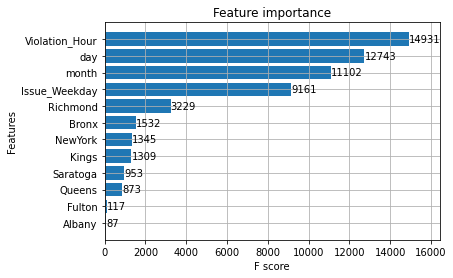

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=9000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_Fine,change_Fine
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,109.020683,5.979317
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,86.628174,-20.628174
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,90.966530,-18.466530
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,86.600372,6.861166
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,81.372665,4.081880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,51.327091,-1.327091
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.716457,-0.716457
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.240833,-0.240833
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,49.444954,0.555046


In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

mean cross validation score: 0.6330344574559371


In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

### avg dt plot

In [ ]:
# df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

# df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_Fine,change_Fine
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,109.020683,5.979317
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,86.628174,-20.628174
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,90.966530,-18.466530
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,86.600372,6.861166
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,81.372665,4.081880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,51.327091,-1.327091
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.716457,-0.716457
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.240833,-0.240833
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,49.444954,0.555046


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- Albany: double (nullable = true)
 |-- Bronx: double (nullable = true)
 |-- Fulton: double (nullable = true)
 |-- Kings: double (nullable = true)
 |-- NewYork: double (nullable = true)
 |-- Putnam: double (nullable = true)
 |-- Queens: double (nullable = true)
 |-- Richmond: double (nullable = true)
 |-- Saratoga: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_Fine: double (nullable = true)
 |-- change_Fine: double (nullable = true)

+------+----------+--------------+-------------+-----------------+----------------+------+-----+------+-----+-------+------+------+--------+--------+----+-----+---+------------------+-------

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_Fine","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|   Prediction_Fine|count(Violation)|
+------------------+--------------+------------------+----------------+
|             115.0|           0.0|109.02068328857422|             1.0|
|              66.0|           1.0|   86.628173828125|            10.0|
|              72.5|           2.0|  90.9665298461914|             2.0|
| 93.46153846153848|           3.0| 86.60037231445312|            13.0|
| 85.45454545454545|           4.0| 81.37266540527344|            11.0|
|             115.0|           5.0| 87.52751159667969|             2.0|
|              50.0|           6.0| 82.31553649902344|             3.0|
| 93.33333333333331|           8.0| 72.10197448730469|             6.0|
|              71.5|           9.0| 71.98101043701172|            10.0|
|              50.0|          10.0| 74.16209411621094|             3.0|
| 72.22222222222223|          11.0| 71.88128662109375|          

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+-----------------+--------------+------------------+----------------+------------------+
| avg(Fine Amount)|Violation_Hour|   Prediction_Fine|count(Violation)|             total|
+-----------------+--------------+------------------+----------------+------------------+
|            115.0|           0.0|109.02068328857422|             1.0|             115.0|
|             66.0|           1.0|   86.628173828125|            10.0|             660.0|
|             72.5|           2.0|  90.9665298461914|             2.0|             145.0|
|93.46153846153848|           3.0| 86.60037231445312|            13.0|1215.0000000000002|
|85.45454545454545|           4.0| 81.37266540527344|            11.0|             940.0|
|            115.0|           5.0| 87.52751159667969|             2.0|             230.0|
|             50.0|           6.0| 82.31553649902344|             3.0|             150.0|
|93.33333333333331|           8.0| 72.10197448730469|             6.0| 559.9999999999999|
|         

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_Fine")))
data_dt_2020_2.show()

+-----------------+--------------+------------------+----------------+------------------+------------------+
| avg(Fine Amount)|Violation_Hour|   Prediction_Fine|count(Violation)|             total|  total_prediction|
+-----------------+--------------+------------------+----------------+------------------+------------------+
|            115.0|           0.0|109.02068328857422|             1.0|             115.0|109.02068328857422|
|             66.0|           1.0|   86.628173828125|            10.0|             660.0|   866.28173828125|
|             72.5|           2.0|  90.9665298461914|             2.0|             145.0| 181.9330596923828|
|93.46153846153848|           3.0| 86.60037231445312|            13.0|1215.0000000000002|1125.8048400878906|
|85.45454545454545|           4.0| 81.37266540527344|            11.0|             940.0| 895.0993194580078|
|            115.0|           5.0| 87.52751159667969|             2.0|             230.0|175.05502319335938|
|             50.0|

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_Fine', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0|1374609.0| 9.7673358E7|    9.610035786436462E7|
|           0.0|  48707.0|   4241605.0|       4117498.82232666|
|           7.0| 921203.0| 7.2657023E7|    7.257816975109863E7|
|          18.0| 453957.0| 2.7069121E7|    3.040695618118286E7|
|           1.0|  75669.0|   6274403.0|      6128005.852481842|
|           4.0|  23696.0|   1986070.0|     1913921.9892120361|
|          23.0|  52742.0|   4650772.0|      4495890.560451508|
|          11.0|1352859.0| 9.1523628E7|    9.135983031554413E7|
|          21.0| 340628.0| 2.0462645E7|    2.260308747358322E7|
|          14.0|1186631.0| 8.3098346E7|    8.487173067578506E7|
|          22.0|  75719.0|   6801943.0|      6503504.925476074|
|           3.0|  37253.0|   3058918.0|     3033044.9055404663|
|          19.0| 342394.0| 1.8375642E7| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+-----------------+-----------------+
|           8.0|1374609.0| 9.7673358E7|    9.610035786436462E7|69.91104951616396|71.05537501936915|
|           0.0|  48707.0|   4241605.0|       4117498.82232666|84.53607946140514|87.08409468864845|
|           7.0| 921203.0| 7.2657023E7|    7.257816975109863E7|78.78629330462302|  78.871891428925|
|          18.0| 453957.0| 2.7069121E7|    3.040695618118286E7|  66.982018519778|59.62926224289966|
|           1.0|  75669.0|   6274403.0|      6128005.852481842|80.98436417134945|82.91906857497787|
|           4.0|  23696.0|   1986070.0|     1913921.9892120361|80.76983411597047|83.81456785955436|
|          23.0|  52742.0|   4650772.0|      4495890.560451508|85.24308066534276|88.17966705851124|


In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+-----------------+-----------------+
|           0.0|  48707.0|   4241605.0|       4117498.82232666|84.53607946140514|87.08409468864845|
|           1.0|  75669.0|   6274403.0|      6128005.852481842|80.98436417134945|82.91906857497787|
|           2.0|  57934.0|   5005492.0|      4934345.874336243|85.17184855760422|86.39990333828149|
|           3.0|  37253.0|   3058918.0|     3033044.9055404663|81.41746719835896|82.11199098059217|
|           4.0|  23696.0|   1986070.0|     1913921.9892120361|80.76983411597047|83.81456785955436|
|           5.0| 104289.0|   9940265.0|      9596703.329681396|  92.020283344182|95.31460652609576|
|           6.0| 515867.0| 4.1080278E7|     4.30440071182518E7|83.44012530022623|79.63346754105226|


In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0    48707.0     4241605.0             4.117499e+06   
1              1.0    75669.0     6274403.0             6.128006e+06   
2              2.0    57934.0     5005492.0             4.934346e+06   
3              3.0    37253.0     3058918.0             3.033045e+06   
4              4.0    23696.0     1986070.0             1.913922e+06   
5              5.0   104289.0     9940265.0             9.596703e+06   
6              6.0   515867.0    41080278.0             4.304401e+07   
7              7.0   921203.0    72657023.0             7.257817e+07   
8              8.0  1374609.0    97673358.0             9.610036e+07   
9              9.0  1376416.0    95161507.0             9.430413e+07   
10            10.0  1166257.0    81312679.0             8.215162e+07   
11            11.0  1352859.0    91523628.0             9.135983e+07   
12            12.0  1279947.0    86630439.0             8.742911

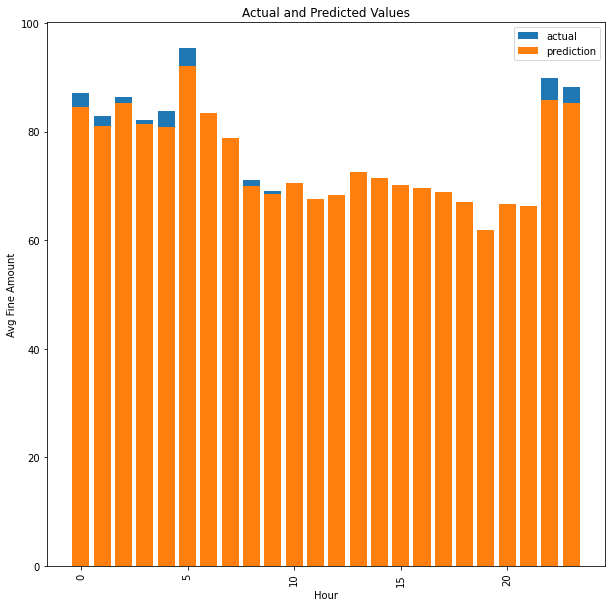

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_1_XGboost_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

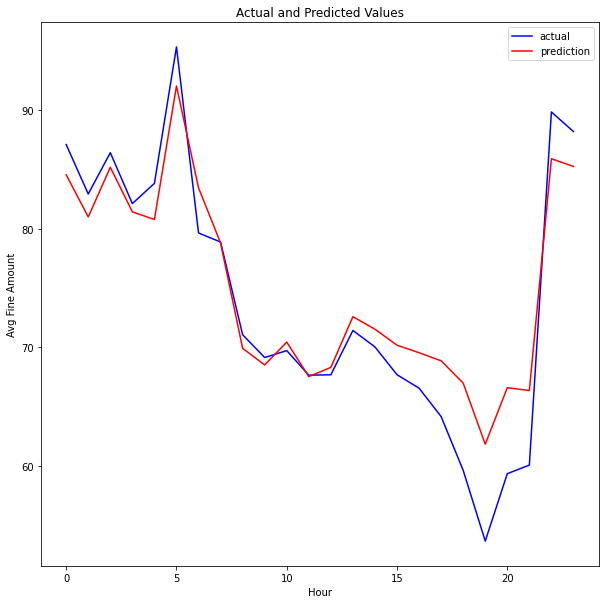

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_1_XGboost_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: 0.43086013222453967
score without cv: 1.0
0.41046043274515354
0.41046043274515354


### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X1
y_train = y1.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

mean cross validation score: 0.6058147670427296


In [ ]:
predicted_test

,predicted_FineAmount
0,97.948894
1,68.643482
2,80.715023
3,75.436717
4,77.535583
...,...
57306,53.125158
57307,51.082198
57308,50.000000
57309,50.000000


### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,97.948894,17.051106
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,68.643482,-2.643482
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,80.715023,-8.215023
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,75.436717,18.024822
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,77.535583,7.918962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,67.815051,-17.815051
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,68.106358,-18.106358
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,69.142333,-19.142333
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,60.457245,-10.457245


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- Albany: double (nullable = true)
 |-- Bronx: double (nullable = true)
 |-- Fulton: double (nullable = true)
 |-- Kings: double (nullable = true)
 |-- NewYork: double (nullable = true)
 |-- Putnam: double (nullable = true)
 |-- Queens: double (nullable = true)
 |-- Richmond: double (nullable = true)
 |-- Saratoga: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+----------+--------------+-------------+-----------------+----------------+------+-----+------+-----+-------+------+------+--------+--------+----+-----+---+--------

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
|             115.0|           0.0|       97.94889378443682|             1.0|
|              66.0|           1.0|       68.64348200593051|            10.0|
|              72.5|           2.0|       80.71502283888603|             2.0|
| 93.46153846153848|           3.0|       75.43671673632288|            13.0|
| 85.45454545454545|           4.0|       77.53558333333334|            11.0|
|             115.0|           5.0|       75.12223510033405|             2.0|
|              50.0|           6.0|       75.78249503941602|             3.0|
| 93.33333333333331|           8.0|       74.75040388099252|             6.0|
|              71.5|           9.0|       82.55584409770793|            10.0|
|              50.0|          10.0|       81.55821432177365|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+-----------------+--------------+------------------------+----------------+------------------+
| avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+-----------------+--------------+------------------------+----------------+------------------+
|            115.0|           0.0|       97.94889378443682|             1.0|             115.0|
|             66.0|           1.0|       68.64348200593051|            10.0|             660.0|
|             72.5|           2.0|       80.71502283888603|             2.0|             145.0|
|93.46153846153848|           3.0|       75.43671673632288|            13.0|1215.0000000000002|
|85.45454545454545|           4.0|       77.53558333333334|            11.0|             940.0|
|            115.0|           5.0|       75.12223510033405|             2.0|             230.0|
|             50.0|           6.0|       75.78249503941602|             3.0|             150.0|
|93.33333333333331|           8.0|      

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+-----------------+--------------+------------------------+----------------+------------------+------------------+
| avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+-----------------+--------------+------------------------+----------------+------------------+------------------+
|            115.0|           0.0|       97.94889378443682|             1.0|             115.0| 97.94889378443682|
|             66.0|           1.0|       68.64348200593051|            10.0|             660.0| 686.4348200593051|
|             72.5|           2.0|       80.71502283888603|             2.0|             145.0|161.43004567777206|
|93.46153846153848|           3.0|       75.43671673632288|            13.0|1215.0000000000002| 980.6773175721975|
|85.45454545454545|           4.0|       77.53558333333334|            11.0|             940.0| 852.8914166666667|
|            115.0|           5.0|       75.12223510033405|             2.0|    

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0|1374609.0| 9.7673358E7|    9.815540920297027E7|
|           0.0|  48707.0|   4241605.0|     4050791.7266834723|
|           7.0| 921203.0| 7.2657023E7|    7.219000052187498E7|
|          18.0| 453957.0| 2.7069121E7|    3.023614273504745E7|
|           1.0|  75669.0|   6274403.0|      6065044.401478049|
|           4.0|  23696.0|   1986070.0|       1925565.19270984|
|          23.0|  52742.0|   4650772.0|      4410819.429328275|
|          11.0|1352859.0| 9.1523628E7|    9.473586448373505E7|
|          21.0| 340628.0| 2.0462645E7|    2.249898943774653E7|
|          14.0|1186631.0| 8.3098346E7|    8.532109918900649E7|
|          22.0|  75719.0|   6801943.0|      6341121.155674265|
|           3.0|  37253.0|   3058918.0|     3011644.0496162996|
|          19.0| 342394.0| 1.8375642E7| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+-----------------+-----------------+
|           8.0|1374609.0| 9.7673358E7|    9.815540920297027E7|  71.406057433765|71.05537501936915|
|           0.0|  48707.0|   4241605.0|     4050791.7266834723|83.16652076053693|87.08409468864845|
|           7.0| 921203.0| 7.2657023E7|    7.219000052187498E7|78.36492121918293|  78.871891428925|
|          18.0| 453957.0| 2.7069121E7|    3.023614273504745E7| 66.6057418104522|59.62926224289966|
|           1.0|  75669.0|   6274403.0|      6065044.401478049| 80.1523001688677|82.91906857497787|
|           4.0|  23696.0|   1986070.0|       1925565.19270984|81.26119145466915|83.81456785955436|
|          23.0|  52742.0|   4650772.0|      4410819.429328275|83.63011317978604|88.17966705851124|


In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+-----------------+-----------------+
|           0.0|  48707.0|   4241605.0|     4050791.7266834723|83.16652076053693|87.08409468864845|
|           1.0|  75669.0|   6274403.0|      6065044.401478049| 80.1523001688677|82.91906857497787|
|           2.0|  57934.0|   5005492.0|      4861210.125884227| 83.9094508558744|86.39990333828149|
|           3.0|  37253.0|   3058918.0|     3011644.0496162996|80.84299384254422|82.11199098059217|
|           4.0|  23696.0|   1986070.0|       1925565.19270984|81.26119145466915|83.81456785955436|
|           5.0| 104289.0|   9940265.0|      9372746.131600387|89.87281622798557|95.31460652609576|
|           6.0| 515867.0| 4.1080278E7|    4.210921211698821E7|81.62804001222837|79.63346754105226|


In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0    48707.0     4241605.0             4.050792e+06   
1              1.0    75669.0     6274403.0             6.065044e+06   
2              2.0    57934.0     5005492.0             4.861210e+06   
3              3.0    37253.0     3058918.0             3.011644e+06   
4              4.0    23696.0     1986070.0             1.925565e+06   
5              5.0   104289.0     9940265.0             9.372746e+06   
6              6.0   515867.0    41080278.0             4.210921e+07   
7              7.0   921203.0    72657023.0             7.219000e+07   
8              8.0  1374609.0    97673358.0             9.815541e+07   
9              9.0  1376416.0    95161507.0             9.698528e+07   
10            10.0  1166257.0    81312679.0             8.414808e+07   
11            11.0  1352859.0    91523628.0             9.473586e+07   
12            12.0  1279947.0    86630439.0             8.945338

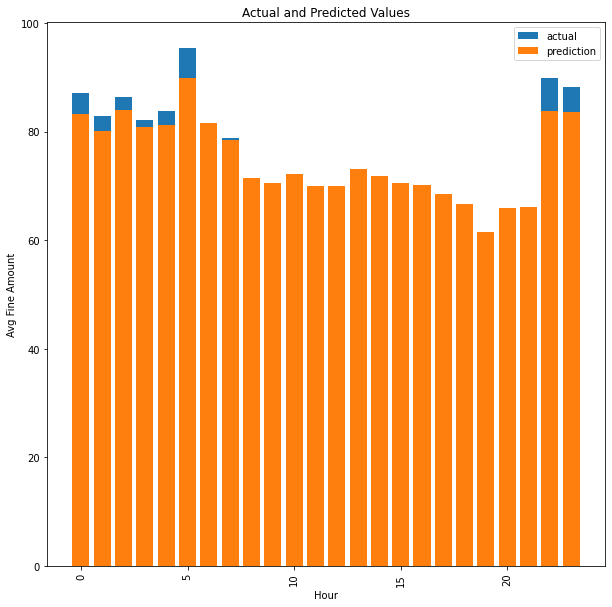

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_1_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

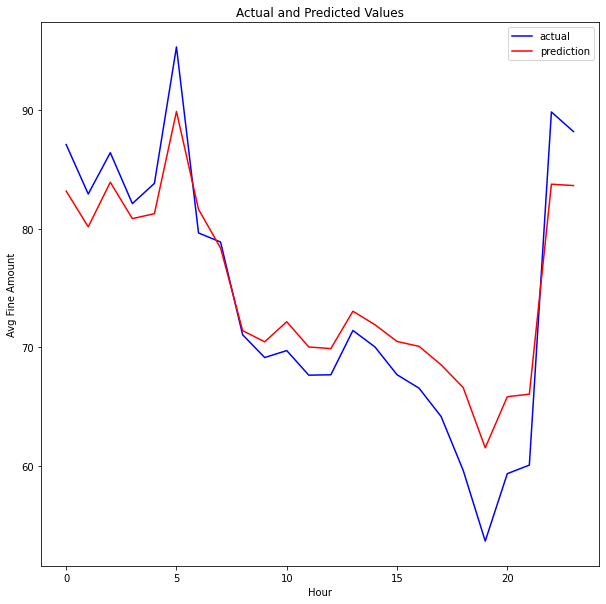

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_1_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

## Model df_2

### df_2 Train & Valid & Test

In [ ]:
df_train = df_2_oh
# df_valid = df_1_oh
df_test = df_2_toh

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X2 = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
# y = df_train[["count(Violation)"]]
y2 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67019 entries, 23784 to 15843
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  67019 non-null  float64
 1   Issue_Weekday   67019 non-null  float64
 2   Kings           67019 non-null  float64
 3   Queens          67019 non-null  float64
 4   Bronx           67019 non-null  float64
 5   Richmond        67019 non-null  float64
 6   NewYork         67019 non-null  float64
 7   Saratoga        67019 non-null  float64
 8   Albany          67019 non-null  float64
 9   Fulton          67019 non-null  float64
 10  Putnam          67019 non-null  float64
 11  month           67019 non-null  float32
 12  day             67019 non-null  float32
 13  AWND            67019 non-null  float64
 14  avg(TAVG)       67019 non-null  float64
 15  avg(SNWD)       67019 non-null  float64
 16  avg(WT01)       67019 non-null  float64
dtypes: float32(2), float64(15)


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(67019, 17)
(67019, 1)
(28723, 17)
(28723, 1)
(56741, 17)
(56741, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
23784,81.939394
40553,62.500000
43797,50.000000
34212,78.709677
31417,51.710037
...,...
6289,92.283951
6661,56.210046
28595,56.873239
860,97.619048


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

Streaming output truncated to the last 5000 lines.
[5546]	validation_0-rmse:9.05553	validation_1-rmse:9.76143
[5547]	validation_0-rmse:9.05549	validation_1-rmse:9.76142
[5548]	validation_0-rmse:9.0554	validation_1-rmse:9.76137
[5549]	validation_0-rmse:9.05533	validation_1-rmse:9.76131
[5550]	validation_0-rmse:9.05527	validation_1-rmse:9.76134
[5551]	validation_0-rmse:9.0552	validation_1-rmse:9.76112
[5552]	validation_0-rmse:9.05514	validation_1-rmse:9.76111
[5553]	validation_0-rmse:9.05504	validation_1-rmse:9.76108
[5554]	validation_0-rmse:9.05484	validation_1-rmse:9.76095
[5555]	validation_0-rmse:9.05477	validation_1-rmse:9.76087
[5556]	validation_0-rmse:9.05471	validation_1-rmse:9.76079
[5557]	validation_0-rmse:9.05466	validation_1-rmse:9.76082
[5558]	validation_0-rmse:9.0546	validation_1-rmse:9.76083
[5559]	validation_0-rmse:9.05438	validation_1-rmse:9.76098
[5560]	validation_0-rmse:9.05433	validation_1-rmse:9.76092
[5561]	validation_0-rmse:9.05424	validation_1-rmse:9.76099
[5562]	v

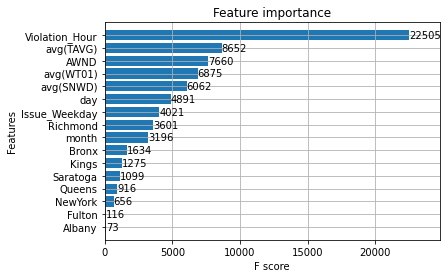

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=15000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_Fine,change_Fine
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,91.347275,23.652725
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,77.498047,-11.498047
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,83.961227,-11.461227
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,84.034607,9.426932
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,75.788704,9.665842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,52.498730,-2.498730
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,51.885227,-1.885227
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.016514,-0.016514
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.822968,-0.822968


In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

mean cross validation score: 0.6365441248225198


In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

Cross validation

In [ ]:
# import  xgboost as xgb
# # from Utils import  pathUtils
# import pandas as pd
# from sklearn.model_selection import  train_test_split
# # from Process.genBasicData import genData
# # from Utils import  feaUtils

# # train_data = genData(pathUtils.train_path)
# # test_data = genData(pathUtils.test_path)

# param = {'max_depth': 3,
#          'learning_rate ': 0.01,
#          'silent': 1,
#          'objective': 'binary:logistic',
#          "eval_metric":"auc",
#          "scale_pos_weight":10,
#          "subsample":0.8,
#          "min_child_weight":1,
#          "n_estimators": 1}

# # features = [i for i in list(train_data.columns) if i not in ["ID","y"]]
# # features = feaUtils.train_fea
# # x_train, x_valid, y_train, y_valid = train_test_split(train_data[features],train_data["y"],
# #                                                       test_size=0.2, random_state=66)

# # x_train, x_valid, y_train, y_valid = X_train, X_valid, y_train, y_valid
# # X_test y_test

# dtrain = xgb.DMatrix(X_train, y_train)
# dvalid = xgb.DMatrix(X_valid, y_valid)
# dtest  = xgb.DMatrix(X_test)


# evallist = [(dtrain,"train"),(dvalid,"valid")]
# num_round = 20000
# bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=30)


# y_pre = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

# res = pd.concat([y_test,pd.DataFrame(y_pre,columns=["pred"])],axis=1)
# # res.to_csv(pathUtils.predict_root_path+"3.csv",index=False)
# res

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: 0.4757292915419006
score without cv: 1.0
0.40951771207123555
0.40951771207123555


### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X2
y_train = y2.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

mean cross validation score: 0.6371058916423926


In [ ]:
predicted_test

,predicted_FineAmount
0,92.990799
1,73.349522
2,84.618208
3,84.380180
4,73.277673
...,...
56736,52.190073
56737,52.389792
56738,50.000000
56739,50.000000


### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Bronx,2020-01-01,0.0,3.0,115.000000,1.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,92.990799,22.009201
1,Bronx,2020-01-01,1.0,3.0,66.000000,10.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,73.349522,-7.349522
2,Bronx,2020-01-01,2.0,3.0,72.500000,2.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,84.618208,-12.118208
3,Bronx,2020-01-01,3.0,3.0,93.461538,13.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,84.380180,9.081358
4,Bronx,2020-01-01,4.0,3.0,85.454545,11.0,15.88,41.0,20.0,32.0,...,0.0,0.0,0.0,0.0,0.0,2020,1.0,1.0,73.277673,12.176873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,73.666285,-23.666285
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,82.195310,-32.195310
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,89.501972,-39.501972
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,79.068360,-29.068360


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- avg(TAVG): double (nullable = true)
 |-- avg(SNWD): double (nullable = true)
 |-- avg(WT01): double (nullable = true)
 |-- Albany: double (nullable = true)
 |-- Bronx: double (nullable = true)
 |-- Fulton: double (nullable = true)
 |-- Kings: double (nullable = true)
 |-- NewYork: double (nullable = true)
 |-- Putnam: double (nullable = true)
 |-- Queens: double (nullable = true)
 |-- Richmond: double (nullable = true)
 |-- Saratoga: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+-----

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
|             115.0|           0.0|       92.99079853876636|             1.0|
|              66.0|           1.0|        73.3495217832016|            10.0|
|              72.5|           2.0|       84.61820780780934|             2.0|
| 93.46153846153848|           3.0|       84.38018006036684|            13.0|
| 85.45454545454545|           4.0|        73.2776725274584|            11.0|
|             115.0|           5.0|       94.16798719962331|             2.0|
|              50.0|           6.0|       81.78849007985794|             3.0|
| 93.33333333333331|           8.0|       68.98248052021304|             6.0|
|              71.5|           9.0|       73.58737114965672|            10.0|
|              50.0|          10.0|       74.46532562536382|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+-----------------+--------------+------------------------+----------------+------------------+
| avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+-----------------+--------------+------------------------+----------------+------------------+
|            115.0|           0.0|       92.99079853876636|             1.0|             115.0|
|             66.0|           1.0|        73.3495217832016|            10.0|             660.0|
|             72.5|           2.0|       84.61820780780934|             2.0|             145.0|
|93.46153846153848|           3.0|       84.38018006036684|            13.0|1215.0000000000002|
|85.45454545454545|           4.0|        73.2776725274584|            11.0|             940.0|
|            115.0|           5.0|       94.16798719962331|             2.0|             230.0|
|             50.0|           6.0|       81.78849007985794|             3.0|             150.0|
|93.33333333333331|           8.0|      

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+-----------------+--------------+------------------------+----------------+------------------+------------------+
| avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+-----------------+--------------+------------------------+----------------+------------------+------------------+
|            115.0|           0.0|       92.99079853876636|             1.0|             115.0| 92.99079853876636|
|             66.0|           1.0|        73.3495217832016|            10.0|             660.0| 733.4952178320159|
|             72.5|           2.0|       84.61820780780934|             2.0|             145.0|169.23641561561868|
|93.46153846153848|           3.0|       84.38018006036684|            13.0|1215.0000000000002| 1096.942340784769|
|85.45454545454545|           4.0|        73.2776725274584|            11.0|             940.0| 806.0543978020424|
|            115.0|           5.0|       94.16798719962331|             2.0|    

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0|1369797.0| 9.7354763E7|    9.968404136003405E7|
|           0.0|  48452.0|   4220135.0|     4118150.5014848798|
|           7.0| 918705.0| 7.2473628E7|     7.10227590580029E7|
|          18.0| 452525.0| 2.6986726E7|   3.0157931748362288E7|
|           1.0|  75351.0|   6248633.0|      6033043.349594098|
|           4.0|  23611.0|   1979100.0|      1898629.182701677|
|          23.0|  52592.0|   4638197.0|      4343138.427137516|
|          11.0|1348128.0| 9.1220803E7|    9.724807801811388E7|
|          21.0| 339462.0|  2.039294E7|    2.356653590659718E7|
|          14.0|1183454.0| 8.2891471E7|    8.652822567692569E7|
|          22.0|  75440.0|   6777298.0|      6198681.391279551|
|           3.0|  37133.0|   3049653.0|      3006103.268307838|
|          19.0| 341450.0| 1.8324367E7| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+------------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|    avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+------------------+-----------------+
|           8.0|1369797.0| 9.7354763E7|    9.968404136003405E7| 72.77285711680932|71.07240196905089|
|           0.0|  48452.0|   4220135.0|     4118150.5014848798| 84.99443782475191|87.09929414678444|
|           7.0| 918705.0| 7.2473628E7|     7.10227590580029E7|  77.3074698167561|78.88672424771825|
|          18.0| 452525.0| 2.6986726E7|   3.0157931748362288E7| 66.64368100847973|59.63587868073587|
|           1.0|  75351.0|   6248633.0|      6033043.349594098| 80.06586972427834|82.92700826797255|
|           4.0|  23611.0|   1979100.0|      1898629.182701677| 80.41290850458164|83.82110033458981|
|          23.0|  52592.0|   4638197.0|      4343138.427137516| 82.58173157775929|88.192063

In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+------------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|    avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+------------------+-----------------+
|           0.0|  48452.0|   4220135.0|     4118150.5014848798| 84.99443782475191|87.09929414678444|
|           1.0|  75351.0|   6248633.0|      6033043.349594098| 80.06586972427834|82.92700826797255|
|           2.0|  57688.0|   4984787.0|       4784958.91669561| 82.94548115198324|86.40942657051727|
|           3.0|  37133.0|   3049653.0|      3006103.268307838| 80.95503375186055|82.12783777233189|
|           4.0|  23611.0|   1979100.0|      1898629.182701677| 80.41290850458164|83.82110033458981|
|           5.0| 103905.0|   9902800.0|       9020978.30006145| 86.81948221992637|95.30628939897021|
|           6.0| 514366.0| 4.0959268E7|    4.164905627120269E7| 80.97163551090603|79.630589

In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0    48452.0     4220135.0             4.118151e+06   
1              1.0    75351.0     6248633.0             6.033043e+06   
2              2.0    57688.0     4984787.0             4.784959e+06   
3              3.0    37133.0     3049653.0             3.006103e+06   
4              4.0    23611.0     1979100.0             1.898629e+06   
5              5.0   103905.0     9902800.0             9.020978e+06   
6              6.0   514366.0    40959268.0             4.164906e+07   
7              7.0   918705.0    72473628.0             7.102276e+07   
8              8.0  1369797.0    97354763.0             9.968404e+07   
9              9.0  1371673.0    94853912.0             9.966308e+07   
10            10.0  1163122.0    81115534.0             8.568330e+07   
11            11.0  1348128.0    91220803.0             9.724808e+07   
12            12.0  1276106.0    86386834.0             9.141226

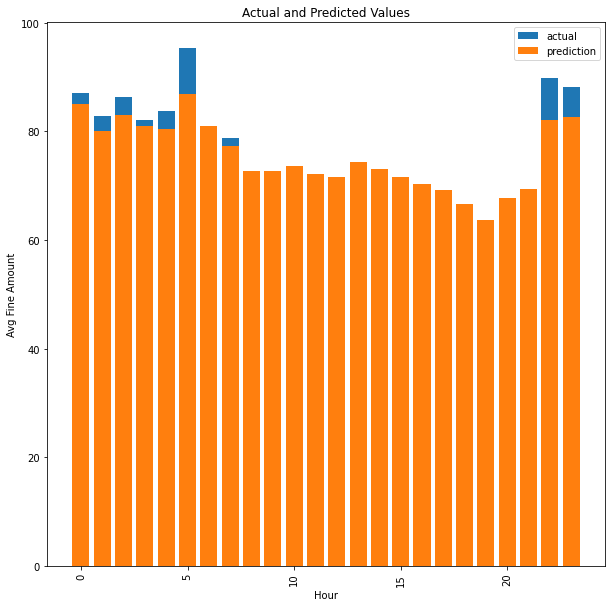

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_2_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

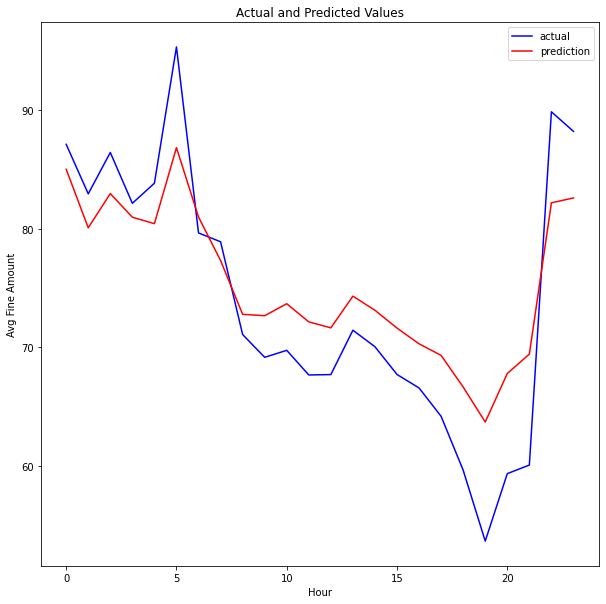

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_2_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

## Model df_3

### df_1 Train & Valid & Test

In [ ]:
df_train = df_3
# df_valid = df_1_oh
df_test = df_3_t

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X3 = df_train[["Violation_Hour", "Issue_Weekday", 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
# y = df_train[["count(Violation)"]]
y3 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12203 entries, 10978 to 15795
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  12203 non-null  float32
 1   Issue_Weekday   12203 non-null  float32
 2   month           12203 non-null  float32
 3   day             12203 non-null  float32
 4   AWND            12203 non-null  float64
 5   avg(TAVG)       12203 non-null  float64
 6   avg(SNWD)       12203 non-null  float64
 7   avg(WT01)       12203 non-null  float64
dtypes: float32(4), float64(4)
memory usage: 667.4 KB


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(12203, 8)
(12203, 1)
(5231, 8)
(5231, 1)
(1842, 8)
(1842, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
10978,82.318841
5743,59.136044
2596,61.119718
13348,60.259109
573,79.692308
...,...
11284,165.000000
11964,67.420091
5390,55.989673
860,79.857143


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

[17:07:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:60.9936	validation_1-rmse:60.8529
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:53.8731	validation_1-rmse:53.728
[2]	validation_0-rmse:47.6319	validation_1-rmse:47.4792
[3]	validation_0-rmse:42.1673	validation_1-rmse:42.007
[4]	validation_0-rmse:37.3859	validation_1-rmse:37.209
[5]	validation_0-rmse:33.2123	validation_1-rmse:33.0212
[6]	validation_0-rmse:29.5747	validation_1-rmse:29.3681
[7]	validation_0-rmse:26.4072	validation_1-rmse:26.1906
[8]	validation_0-rmse:23.6685	validation_1-rmse:23.4346
[9]	validation_0-rmse:21.2967	validation_1-rmse:21.0478
[10]	validation_0-rmse:19.2664	validation_1-rmse:19.0001
[11]	validation_0-rmse:17.522	validation_1-rmse:17.2405
[12]	validation_0-rmse:16.0414	validation_

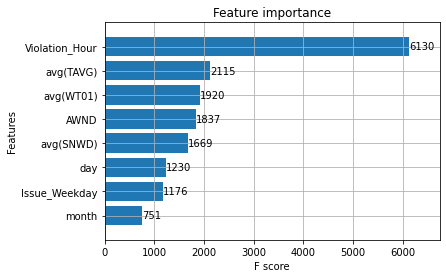

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=15000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

In [ ]:
df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day,Prediction_Fine,change_Fine
0,Queens,2022-01-01,0.0,6.0,95.000000,3.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,97.266731,-2.266731
1,Queens,2022-01-01,1.0,6.0,67.600000,25.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,82.419685,-14.819685
2,Queens,2022-01-01,2.0,6.0,78.095238,21.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,83.858604,-5.763366
3,Queens,2022-01-01,3.0,6.0,77.142857,28.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,78.098557,-0.955699
4,Queens,2022-01-01,4.0,6.0,65.000000,18.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,79.395851,-14.395851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3.0,2.0,115.000000,1.0,16.11,54.0,25.5,30.00,2022,3.0,22.0,81.629646,33.370354
1838,Queens,2022-03-23,22.0,3.0,95.000000,1.0,11.63,46.0,22.5,23.00,2022,3.0,23.0,81.711960,13.288040
1839,Queens,2022-04-05,18.0,2.0,115.000000,1.0,7.61,52.0,24.5,19.90,2022,4.0,5.0,66.525505,48.474495
1840,Queens,2022-04-07,20.0,4.0,115.000000,1.0,16.78,52.0,24.0,25.55,2022,4.0,7.0,65.166809,49.833191


In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

mean cross validation score: 0.5082530267850702


In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

Cross validation

In [ ]:
# import  xgboost as xgb
# # from Utils import  pathUtils
# import pandas as pd
# from sklearn.model_selection import  train_test_split
# # from Process.genBasicData import genData
# # from Utils import  feaUtils

# # train_data = genData(pathUtils.train_path)
# # test_data = genData(pathUtils.test_path)

# param = {'max_depth': 3,
#          'learning_rate ': 0.01,
#          'silent': 1,
#          'objective': 'binary:logistic',
#          "eval_metric":"auc",
#          "scale_pos_weight":10,
#          "subsample":0.8,
#          "min_child_weight":1,
#          "n_estimators": 1}

# # features = [i for i in list(train_data.columns) if i not in ["ID","y"]]
# # features = feaUtils.train_fea
# # x_train, x_valid, y_train, y_valid = train_test_split(train_data[features],train_data["y"],
# #                                                       test_size=0.2, random_state=66)

# # x_train, x_valid, y_train, y_valid = X_train, X_valid, y_train, y_valid
# # X_test y_test

# dtrain = xgb.DMatrix(X_train, y_train)
# dvalid = xgb.DMatrix(X_valid, y_valid)
# dtest  = xgb.DMatrix(X_test)


# evallist = [(dtrain,"train"),(dvalid,"valid")]
# num_round = 20000
# bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=30)


# y_pre = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

# res = pd.concat([y_test,pd.DataFrame(y_pre,columns=["pred"])],axis=1)
# # res.to_csv(pathUtils.predict_root_path+"3.csv",index=False)
# res

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: 0.2096522659160729
score without cv: 1.0
0.19492390303984153
0.19492390303984153


### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X3
y_train = y3.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

mean cross validation score: 0.5163270132965445


In [ ]:
predicted_test

,predicted_FineAmount
0,91.495431
1,81.839517
2,84.308576
3,76.459414
4,81.252894
...,...
1837,74.355954
1838,75.443414
1839,62.487194
1840,65.422429


### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Queens,2022-01-01,0.0,6.0,95.000000,3.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,92.990799,2.009201
1,Queens,2022-01-01,1.0,6.0,67.600000,25.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,73.349522,-5.749522
2,Queens,2022-01-01,2.0,6.0,78.095238,21.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,84.618208,-6.522970
3,Queens,2022-01-01,3.0,6.0,77.142857,28.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,84.380180,-7.237323
4,Queens,2022-01-01,4.0,6.0,65.000000,18.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,73.277673,-8.277673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3.0,2.0,115.000000,1.0,16.11,54.0,25.5,30.00,2022,3.0,22.0,79.637557,35.362443
1838,Queens,2022-03-23,22.0,3.0,95.000000,1.0,11.63,46.0,22.5,23.00,2022,3.0,23.0,96.626278,-1.626278
1839,Queens,2022-04-05,18.0,2.0,115.000000,1.0,7.61,52.0,24.5,19.90,2022,4.0,5.0,94.955014,20.044986
1840,Queens,2022-04-07,20.0,4.0,115.000000,1.0,16.78,52.0,24.0,25.55,2022,4.0,7.0,94.489987,20.510013


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- avg(TAVG): double (nullable = true)
 |-- avg(SNWD): double (nullable = true)
 |-- avg(WT01): double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+----------+--------------+-------------+------------------+----------------+----+---------+---------+---------+----+-----+---+------------------------+--------------------+
|County|      DATE|Violation_Hour|Issue_Weekday|  avg(Fine Amount)|count(Violation)|AWND|avg(TAVG)|avg(SNWD)|avg(WT01)|year|month|day|Prediction_FineAmount_RF|change_FineAmount_

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
|              95.0|           0.0|       92.99079853876636|             3.0|
|              67.6|           1.0|        73.3495217832016|            25.0|
|  78.0952380952381|           2.0|       84.61820780780934|            21.0|
| 77.14285714285714|           3.0|       84.38018006036684|            28.0|
|              65.0|           4.0|        73.2776725274584|            18.0|
|59.285714285714285|           5.0|       94.16798719962331|            14.0|
|            71.875|           6.0|       81.78849007985794|             8.0|
|              50.0|           7.0|       68.98248052021304|            13.0|
|  67.6923076923077|           8.0|       73.58737114965672|            13.0|
| 88.94736842105263|           9.0|       74.46532562536382|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+------------------+--------------+------------------------+----------------+------------------+
|              95.0|           0.0|       92.99079853876636|             3.0|             285.0|
|              67.6|           1.0|        73.3495217832016|            25.0|1689.9999999999998|
|  78.0952380952381|           2.0|       84.61820780780934|            21.0|1640.0000000000002|
| 77.14285714285714|           3.0|       84.38018006036684|            28.0|            2160.0|
|              65.0|           4.0|        73.2776725274584|            18.0|            1170.0|
|59.285714285714285|           5.0|       94.16798719962331|            14.0|             830.0|
|            71.875|           6.0|       81.78849007985794|             8.0|             575.0|
|              50.0|          

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+------------------+--------------+------------------------+----------------+------------------+------------------+
|              95.0|           0.0|       92.99079853876636|             3.0|             285.0| 278.9723956162991|
|              67.6|           1.0|        73.3495217832016|            25.0|1689.9999999999998|  1833.73804458004|
|  78.0952380952381|           2.0|       84.61820780780934|            21.0|1640.0000000000002|1776.9823639639962|
| 77.14285714285714|           3.0|       84.38018006036684|            28.0|            2160.0|2362.6450416902717|
|              65.0|           4.0|        73.2776725274584|            18.0|            1170.0|1318.9981054942514|
|59.285714285714285|           5.0|       94.16798719962331|            

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0|  64228.0|   4109214.0|      4472921.234837157|
|           0.0|   1535.0|    126075.0|     135657.05788975174|
|           7.0|  44234.0|   3102450.0|     3069873.2600769587|
|          18.0|  22109.0|   1272375.0|     1795995.5687876663|
|           1.0|   4105.0|    349035.0|      363452.0356081239|
|           4.0|    892.0|     67145.0|       80225.7616066522|
|          23.0|   2246.0|    182026.0|     202993.18342699873|
|          11.0|  64263.0|   3904060.0|      4601695.000460798|
|          21.0|  23899.0|   1372080.0|     2109128.1281410772|
|          14.0|  63389.0|   3792070.0|      4511464.802976541|
|          22.0|   4357.0|    369595.0|     391749.96576031484|
|           3.0|   1801.0|    143440.0|     160206.10148019003|
|          19.0|  20355.0|   1069260.0| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           8.0|  64228.0|   4109214.0|      4472921.234837157|69.64129717315122| 63.97854518278633|
|           0.0|   1535.0|    126075.0|     135657.05788975174|88.37593347866563| 82.13355048859935|
|           7.0|  44234.0|   3102450.0|     3069873.2600769587| 69.4007609548528| 70.13722475923498|
|          18.0|  22109.0|   1272375.0|     1795995.5687876663|81.23368622677037|57.550092722420736|
|           1.0|   4105.0|    349035.0|      363452.0356081239|88.53886372914101| 85.02679658952496|
|           4.0|    892.0|     67145.0|       80225.7616066522|89.93919462629171| 75.27466367713005|
|          23.0|   2246.0|    182026.0|     202993.18342699873| 90.3798679550306| 81.044523

In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           0.0|   1535.0|    126075.0|     135657.05788975174|88.37593347866563| 82.13355048859935|
|           1.0|   4105.0|    349035.0|      363452.0356081239|88.53886372914101| 85.02679658952496|
|           2.0|   3597.0|    308185.0|     318508.96364827466|88.54850254330682| 85.67834306366416|
|           3.0|   1801.0|    143440.0|     160206.10148019003|88.95397083852862|  79.6446418656302|
|           4.0|    892.0|     67145.0|       80225.7616066522|89.93919462629171| 75.27466367713005|
|           5.0|   5350.0|    497225.0|     445476.42693883716|83.26662185772658|  92.9392523364486|
|           6.0|  34072.0|   2631680.0|     2511480.7827227735|73.71098798787196| 77.238788

In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0     1535.0      126075.0             1.356571e+05   
1              1.0     4105.0      349035.0             3.634520e+05   
2              2.0     3597.0      308185.0             3.185090e+05   
3              3.0     1801.0      143440.0             1.602061e+05   
4              4.0      892.0       67145.0             8.022576e+04   
5              5.0     5350.0      497225.0             4.454764e+05   
6              6.0    34072.0     2631680.0             2.511481e+06   
7              7.0    44234.0     3102450.0             3.069873e+06   
8              8.0    64228.0     4109214.0             4.472921e+06   
9              9.0    64000.0     3860050.0             4.505447e+06   
10            10.0    61343.0     3707458.0             4.310163e+06   
11            11.0    64263.0     3904060.0             4.601695e+06   
12            12.0    62452.0     3678145.0             4.482438

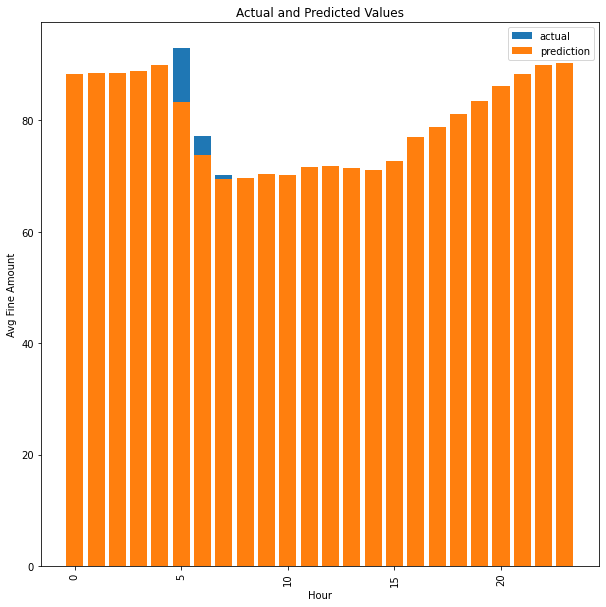

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_3_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

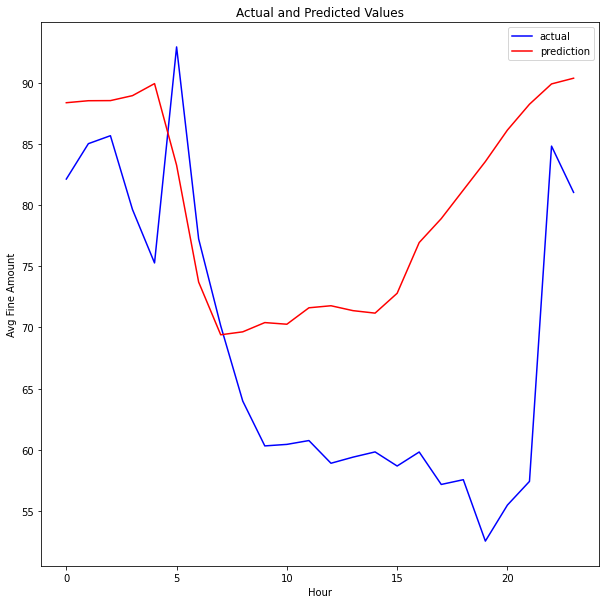

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2020&2022/'
filenames = 'Test2020&22_df_3_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

# Model_For test (2022)

## Model df_1

### df_1 Train & Valid & Test

In [ ]:
df_train = df_1_oh
# df_valid = df_1_oh
df_test = df_1_toh1

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X1 = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# y = df_train[["count(Violation)"]]
y1 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67094 entries, 9222 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  67094 non-null  float64
 1   Issue_Weekday   67094 non-null  float64
 2   Kings           67094 non-null  float64
 3   Queens          67094 non-null  float64
 4   Bronx           67094 non-null  float64
 5   Richmond        67094 non-null  float64
 6   NewYork         67094 non-null  float64
 7   Saratoga        67094 non-null  float64
 8   Albany          67094 non-null  float64
 9   Fulton          67094 non-null  float64
 10  Putnam          67094 non-null  float64
 11  month           67094 non-null  float32
 12  day             67094 non-null  float32
dtypes: float32(2), float64(11)
memory usage: 6.7 MB


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(67094, 13)
(67094, 1)
(28755, 13)
(28755, 1)
(10235, 13)
(10235, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
9222,60.890411
40291,50.000000
42349,50.000000
31684,59.222114
3722,68.461538
...,...
6265,92.123288
6554,102.714286
28488,76.666667
860,97.619048


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

Streaming output truncated to the last 5000 lines.
[3277]	validation_0-rmse:9.5396	validation_1-rmse:10.0457
[3278]	validation_0-rmse:9.53953	validation_1-rmse:10.0458
[3279]	validation_0-rmse:9.53935	validation_1-rmse:10.0457
[3280]	validation_0-rmse:9.53932	validation_1-rmse:10.0458
[3281]	validation_0-rmse:9.53924	validation_1-rmse:10.0458
[3282]	validation_0-rmse:9.53922	validation_1-rmse:10.0458
[3283]	validation_0-rmse:9.53916	validation_1-rmse:10.0459
[3284]	validation_0-rmse:9.53908	validation_1-rmse:10.0459
[3285]	validation_0-rmse:9.53897	validation_1-rmse:10.0459
[3286]	validation_0-rmse:9.53884	validation_1-rmse:10.0457
[3287]	validation_0-rmse:9.53875	validation_1-rmse:10.0456
[3288]	validation_0-rmse:9.53867	validation_1-rmse:10.0455
[3289]	validation_0-rmse:9.53862	validation_1-rmse:10.0455
[3290]	validation_0-rmse:9.53855	validation_1-rmse:10.0454
[3291]	validation_0-rmse:9.53848	validation_1-rmse:10.0455
[3292]	validation_0-rmse:9.5384	validation_1-rmse:10.0453
[3293]	

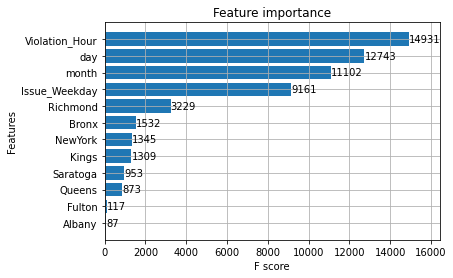

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=15000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_Fine,change_Fine
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,88.500656,-2.618303
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,88.813438,-13.396772
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,85.253998,-24.420664
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,80.252541,5.461745
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,91.920692,-19.063550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,51.327091,-1.327091
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.716457,-0.716457
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.240833,-0.240833
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,49.444954,0.555046


In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

mean cross validation score: 0.572398770700168


In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

Cross validation

In [ ]:
# import  xgboost as xgb
# # from Utils import  pathUtils
# import pandas as pd
# from sklearn.model_selection import  train_test_split
# # from Process.genBasicData import genData
# # from Utils import  feaUtils

# # train_data = genData(pathUtils.train_path)
# # test_data = genData(pathUtils.test_path)

# param = {'max_depth': 3,
#          'learning_rate ': 0.01,
#          'silent': 1,
#          'objective': 'binary:logistic',
#          "eval_metric":"auc",
#          "scale_pos_weight":10,
#          "subsample":0.8,
#          "min_child_weight":1,
#          "n_estimators": 1}

# # features = [i for i in list(train_data.columns) if i not in ["ID","y"]]
# # features = feaUtils.train_fea
# # x_train, x_valid, y_train, y_valid = train_test_split(train_data[features],train_data["y"],
# #                                                       test_size=0.2, random_state=66)

# # x_train, x_valid, y_train, y_valid = X_train, X_valid, y_train, y_valid
# # X_test y_test

# dtrain = xgb.DMatrix(X_train, y_train)
# dvalid = xgb.DMatrix(X_valid, y_valid)
# dtest  = xgb.DMatrix(X_test)


# evallist = [(dtrain,"train"),(dvalid,"valid")]
# num_round = 20000
# bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=30)


# y_pre = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

# res = pd.concat([y_test,pd.DataFrame(y_pre,columns=["pred"])],axis=1)
# # res.to_csv(pathUtils.predict_root_path+"3.csv",index=False)
# res

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: 0.43086013222453967
score without cv: 1.0
0.3422180884836056
0.3422180884836056


### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X1
y_train = y1.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

mean cross validation score: 0.5516540479255132


In [ ]:
predicted_test

,predicted_FineAmount
0,80.009940
1,68.540471
2,77.103891
3,61.940379
4,89.581161
...,...
10230,53.125158
10231,51.082198
10232,50.000000
10233,50.000000


### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),Albany,Bronx,Fulton,Kings,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,80.009940,5.872413
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,68.540471,6.876196
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,77.103891,-16.270557
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,61.940379,23.773906
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,89.581161,-16.724018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,53.125158,-3.125158
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,51.082198,-1.082198
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.000000,0.000000
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,50.000000,0.000000


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- Albany: double (nullable = true)
 |-- Bronx: double (nullable = true)
 |-- Fulton: double (nullable = true)
 |-- Kings: double (nullable = true)
 |-- NewYork: double (nullable = true)
 |-- Putnam: double (nullable = true)
 |-- Queens: double (nullable = true)
 |-- Richmond: double (nullable = true)
 |-- Saratoga: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+----------+--------------+-------------+------------------+----------------+------+-----+------+-----+-------+------+------+--------+--------+----+-----+---+-------

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
| 85.88235294117646|           1.0|       80.00993982863231|            17.0|
| 75.41666666666667|           2.0|       68.54047071839277|            12.0|
|60.833333333333336|           3.0|        77.1038905302415|             6.0|
| 85.71428571428571|           4.0|       61.94037928737927|            14.0|
| 72.85714285714286|           5.0|       89.58116122399662|             7.0|
| 68.33333333333333|           6.0|       93.99264909637961|             6.0|
|              80.0|           7.0|       65.57189201970239|             3.0|
|             93.75|           8.0|       65.48084932691151|             4.0|
| 93.57142857142856|           9.0|       84.50944890985865|            14.0|
|              93.0|          10.0|       85.74934141075778|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+------------------+--------------+------------------------+----------------+------------------+
| 85.88235294117646|           1.0|       80.00993982863231|            17.0|            1460.0|
| 75.41666666666667|           2.0|       68.54047071839277|            12.0|             905.0|
|60.833333333333336|           3.0|        77.1038905302415|             6.0|             365.0|
| 85.71428571428571|           4.0|       61.94037928737927|            14.0|            1200.0|
| 72.85714285714286|           5.0|       89.58116122399662|             7.0|             510.0|
| 68.33333333333333|           6.0|       93.99264909637961|             6.0|             410.0|
|              80.0|           7.0|       65.57189201970239|             3.0|             240.0|
|             93.75|          

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+------------------+--------------+------------------------+----------------+------------------+------------------+
| 85.88235294117646|           1.0|       80.00993982863231|            17.0|            1460.0|1360.1689770867492|
| 75.41666666666667|           2.0|       68.54047071839277|            12.0|             905.0| 822.4856486207132|
|60.833333333333336|           3.0|        77.1038905302415|             6.0|             365.0|  462.623343181449|
| 85.71428571428571|           4.0|       61.94037928737927|            14.0|            1200.0| 867.1653100233098|
| 72.85714285714286|           5.0|       89.58116122399662|             7.0|             510.0| 627.0681285679764|
| 68.33333333333333|           6.0|       93.99264909637961|            

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0| 242377.0| 1.7451209E7|    1.747666020194584E7|
|           0.0|   8335.0|    734185.0|      717761.7236190622|
|           7.0| 170993.0|  1.362126E7|   1.3897481402751662E7|
|          18.0|  64368.0|   4015710.0|     4553487.4655973585|
|           1.0|  14641.0|   1272955.0|      1239090.585981662|
|           4.0|   3471.0|    284305.0|       282456.225541311|
|          23.0|   8848.0|    770226.0|      772800.8335517321|
|          11.0| 248791.0|  1.704987E7|   1.7198044240809154E7|
|          21.0|  66065.0|   3999405.0|       4463716.61345486|
|          14.0| 204582.0| 1.4261935E7|   1.4631842228434168E7|
|          22.0|  14778.0|   1322305.0|     1313466.7632482168|
|           3.0|   6093.0|    513649.0|     509786.01306191506|
|          19.0|  54637.0|   3024620.0| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           8.0| 242377.0| 1.7451209E7|    1.747666020194584E7|72.10527484846268| 72.00026817726105|
|           0.0|   8335.0|    734185.0|      717761.7236190622|86.11418399748797| 88.08458308338332|
|           7.0| 170993.0|  1.362126E7|   1.3897481402751662E7|81.27514812157025| 79.65975215359693|
|          18.0|  64368.0|   4015710.0|     4553487.4655973585|70.74147815059281|62.386744966442954|
|           1.0|  14641.0|   1272955.0|      1239090.585981662|84.63155426416651| 86.94453930742435|
|           4.0|   3471.0|    284305.0|       282456.225541311|81.37603732103457| 81.90867185249208|
|          23.0|   8848.0|    770226.0|      772800.8335517321|87.34186635982506| 87.050858

In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           0.0|   8335.0|    734185.0|      717761.7236190622|86.11418399748797| 88.08458308338332|
|           1.0|  14641.0|   1272955.0|      1239090.585981662|84.63155426416651| 86.94453930742435|
|           2.0|  11368.0|    999855.0|     1009016.4658183046|88.75936539569885| 87.95346586910627|
|           3.0|   6093.0|    513649.0|     509786.01306191506| 83.6674894242434| 84.30149351715083|
|           4.0|   3471.0|    284305.0|       282456.225541311|81.37603732103457| 81.90867185249208|
|           5.0|  21247.0|   2012640.0|     1975739.0927794161|92.98908517811532| 94.72584364851508|
|           6.0| 101255.0|   8264714.0|      8746301.888039712|86.37896289605168| 81.622774

In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0     8335.0      734185.0             7.177617e+05   
1              1.0    14641.0     1272955.0             1.239091e+06   
2              2.0    11368.0      999855.0             1.009016e+06   
3              3.0     6093.0      513649.0             5.097860e+05   
4              4.0     3471.0      284305.0             2.824562e+05   
5              5.0    21247.0     2012640.0             1.975739e+06   
6              6.0   101255.0     8264714.0             8.746302e+06   
7              7.0   170993.0    13621260.0             1.389748e+07   
8              8.0   242377.0    17451209.0             1.747666e+07   
9              9.0   247429.0    17173585.0             1.742829e+07   
10            10.0   218706.0    15114273.0             1.550065e+07   
11            11.0   248791.0    17049870.0             1.719804e+07   
12            12.0   241713.0    16606890.0             1.690118

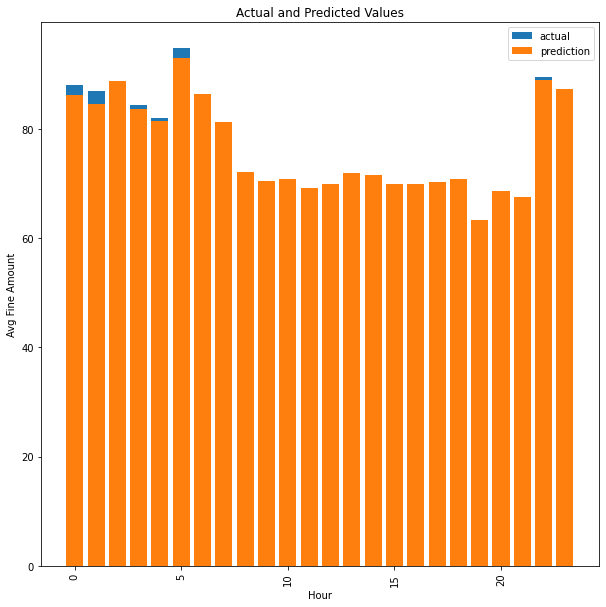

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_1_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

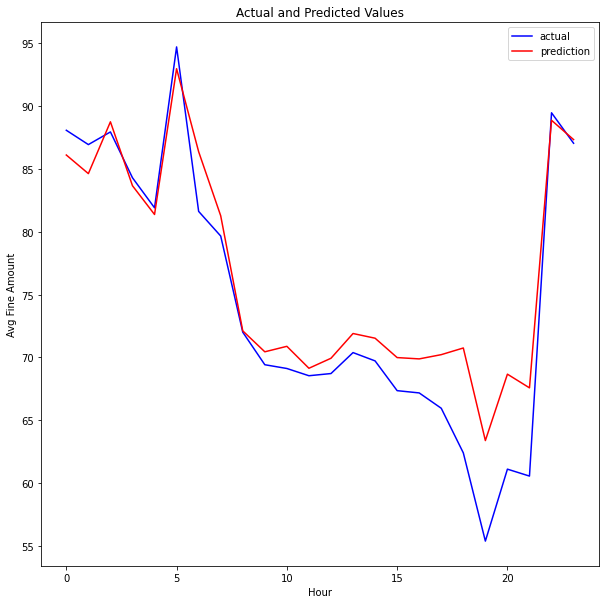

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_1_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

## Model df_2

### df_2 Train & Valid & Test

In [ ]:
df_train = df_2_oh
# df_valid = df_1_oh
df_test = df_2_toh1

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X2 = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
# y = df_train[["count(Violation)"]]
y2 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67019 entries, 23784 to 15843
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  67019 non-null  float64
 1   Issue_Weekday   67019 non-null  float64
 2   Kings           67019 non-null  float64
 3   Queens          67019 non-null  float64
 4   Bronx           67019 non-null  float64
 5   Richmond        67019 non-null  float64
 6   NewYork         67019 non-null  float64
 7   Saratoga        67019 non-null  float64
 8   Albany          67019 non-null  float64
 9   Fulton          67019 non-null  float64
 10  Putnam          67019 non-null  float64
 11  month           67019 non-null  float32
 12  day             67019 non-null  float32
 13  AWND            67019 non-null  float64
 14  avg(TAVG)       67019 non-null  float64
 15  avg(SNWD)       67019 non-null  float64
 16  avg(WT01)       67019 non-null  float64
dtypes: float32(2), float64(15)


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(67019, 17)
(67019, 1)
(28723, 17)
(28723, 1)
(9773, 17)
(9773, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
23784,81.939394
40553,62.500000
43797,50.000000
34212,78.709677
31417,51.710037
...,...
6289,92.283951
6661,56.210046
28595,56.873239
860,97.619048


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=15000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

In [ ]:
df_test

In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

Cross validation

In [ ]:
# import  xgboost as xgb
# # from Utils import  pathUtils
# import pandas as pd
# from sklearn.model_selection import  train_test_split
# # from Process.genBasicData import genData
# # from Utils import  feaUtils

# # train_data = genData(pathUtils.train_path)
# # test_data = genData(pathUtils.test_path)

# param = {'max_depth': 3,
#          'learning_rate ': 0.01,
#          'silent': 1,
#          'objective': 'binary:logistic',
#          "eval_metric":"auc",
#          "scale_pos_weight":10,
#          "subsample":0.8,
#          "min_child_weight":1,
#          "n_estimators": 1}

# # features = [i for i in list(train_data.columns) if i not in ["ID","y"]]
# # features = feaUtils.train_fea
# # x_train, x_valid, y_train, y_valid = train_test_split(train_data[features],train_data["y"],
# #                                                       test_size=0.2, random_state=66)

# # x_train, x_valid, y_train, y_valid = X_train, X_valid, y_train, y_valid
# # X_test y_test

# dtrain = xgb.DMatrix(X_train, y_train)
# dvalid = xgb.DMatrix(X_valid, y_valid)
# dtest  = xgb.DMatrix(X_test)


# evallist = [(dtrain,"train"),(dvalid,"valid")]
# num_round = 20000
# bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=30)


# y_pre = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

# res = pd.concat([y_test,pd.DataFrame(y_pre,columns=["pred"])],axis=1)
# # res.to_csv(pathUtils.predict_root_path+"3.csv",index=False)
# res

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X2
y_train = y2.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

mean cross validation score: 0.6514143060225555


In [ ]:
predicted_test

,predicted_FineAmount
0,82.151006
1,82.110485
2,84.377502
3,79.862595
4,85.585085
...,...
9768,52.190073
9769,52.389792
9770,50.000000
9771,50.000000


### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),...,NewYork,Putnam,Queens,Richmond,Saratoga,year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Bronx,2022-01-01,1.0,6.0,85.882353,17.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,82.151006,3.731347
1,Bronx,2022-01-01,2.0,6.0,75.416667,12.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,82.110485,-6.693818
2,Bronx,2022-01-01,3.0,6.0,60.833333,6.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,84.377502,-23.544168
3,Bronx,2022-01-01,4.0,6.0,85.714286,14.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,79.862595,5.851690
4,Bronx,2022-01-01,5.0,6.0,72.857143,7.0,6.26,55.0,26.5,9.0,...,0.0,0.0,0.0,0.0,0.0,2022,1.0,1.0,85.585085,-12.727943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,Saratoga,2022-03-15,17.0,2.0,50.000000,53.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,NaN,NaN
10231,Saratoga,2022-03-15,18.0,2.0,50.000000,43.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,NaN,NaN
10232,Saratoga,2022-03-15,19.0,2.0,50.000000,29.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,NaN,NaN
10233,Saratoga,2022-03-15,20.0,2.0,50.000000,21.0,9.17,60.5,26.5,29.1,...,0.0,0.0,0.0,0.0,1.0,2022,3.0,15.0,NaN,NaN


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- avg(TAVG): double (nullable = true)
 |-- avg(SNWD): double (nullable = true)
 |-- avg(WT01): double (nullable = true)
 |-- Albany: double (nullable = true)
 |-- Bronx: double (nullable = true)
 |-- Fulton: double (nullable = true)
 |-- Kings: double (nullable = true)
 |-- NewYork: double (nullable = true)
 |-- Putnam: double (nullable = true)
 |-- Queens: double (nullable = true)
 |-- Richmond: double (nullable = true)
 |-- Saratoga: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+-----

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
| 85.88235294117646|           1.0|       82.15100612948939|            17.0|
| 75.41666666666667|           2.0|       82.11048459550972|            12.0|
|60.833333333333336|           3.0|       84.37750167846487|             6.0|
| 85.71428571428571|           4.0|       79.86259545627598|            14.0|
| 72.85714285714286|           5.0|       85.58508549564276|             7.0|
| 68.33333333333333|           6.0|       99.22744624264091|             6.0|
|              80.0|           7.0|       65.03564763481764|             3.0|
|             93.75|           8.0|       69.65663739526326|             4.0|
| 93.57142857142856|           9.0|        77.9775029692518|            14.0|
|              93.0|          10.0|       78.58213179224366|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+------------------+--------------+------------------------+----------------+------------------+
| 85.88235294117646|           1.0|       82.15100612948939|            17.0|            1460.0|
| 75.41666666666667|           2.0|       82.11048459550972|            12.0|             905.0|
|60.833333333333336|           3.0|       84.37750167846487|             6.0|             365.0|
| 85.71428571428571|           4.0|       79.86259545627598|            14.0|            1200.0|
| 72.85714285714286|           5.0|       85.58508549564276|             7.0|             510.0|
| 68.33333333333333|           6.0|       99.22744624264091|             6.0|             410.0|
|              80.0|           7.0|       65.03564763481764|             3.0|             240.0|
|             93.75|          

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+------------------+--------------+------------------------+----------------+------------------+------------------+
| 85.88235294117646|           1.0|       82.15100612948939|            17.0|            1460.0|1396.5671042013196|
| 75.41666666666667|           2.0|       82.11048459550972|            12.0|             905.0| 985.3258151461166|
|60.833333333333336|           3.0|       84.37750167846487|             6.0|             365.0|506.26501007078923|
| 85.71428571428571|           4.0|       79.86259545627598|            14.0|            1200.0|1118.0763363878636|
| 72.85714285714286|           5.0|       85.58508549564276|             7.0|             510.0| 599.0955984694994|
| 68.33333333333333|           6.0|       99.22744624264091|            

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0| 242335.0| 1.7447459E7|                    NaN|
|           0.0|   8328.0|    733380.0|      631356.7707730721|
|           7.0| 170981.0|  1.362028E7|                    NaN|
|          18.0|  64341.0|   4012900.0|                    NaN|
|           1.0|  14615.0|   1270135.0|                    NaN|
|           4.0|   3463.0|    283595.0|                    NaN|
|          23.0|   8842.0|    769711.0|                    NaN|
|          11.0| 248752.0|  1.704669E7|                    NaN|
|          21.0|  66051.0|   3998040.0|                    NaN|
|          14.0| 204569.0|   1.42606E7|                    NaN|
|          22.0|  14761.0|   1320590.0|                    NaN|
|           3.0|   6074.0|    511794.0|                    NaN|
|          19.0|  54618.0|   3022725.0| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           8.0| 242335.0| 1.7447459E7|                    NaN|              NaN| 71.99727237089154|
|           0.0|   8328.0|    733380.0|      631356.7707730721|75.81133174508551| 88.06195965417868|
|           7.0| 170981.0|  1.362028E7|                    NaN|              NaN| 79.65961130184056|
|          18.0|  64341.0|   4012900.0|                    NaN|              NaN| 62.36925133274273|
|           1.0|  14615.0|   1270135.0|                    NaN|              NaN| 86.90626069107081|
|           4.0|   3463.0|    283595.0|                    NaN|              NaN| 81.89286745596304|
|          23.0|   8842.0|    769711.0|                    NaN|              NaN|  87.05168

In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+-----------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|         avg_fine|
+--------------+---------+------------+-----------------------+-----------------+-----------------+
|           0.0|   8328.0|    733380.0|      631356.7707730721|75.81133174508551|88.06195965417868|
|           1.0|  14615.0|   1270135.0|                    NaN|              NaN|86.90626069107081|
|           2.0|  11341.0|    997255.0|                    NaN|              NaN|87.93360373864739|
|           3.0|   6074.0|    511794.0|                    NaN|              NaN|84.25979585116892|
|           4.0|   3463.0|    283595.0|                    NaN|              NaN|81.89286745596304|
|           5.0|  21238.0|   2011655.0|                    NaN|              NaN|94.71960636594783|
|           6.0| 101247.0|   8263814.0|                    NaN|              NaN|81.62033442966211|


In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0     8328.0      733380.0            631356.770773   
1              1.0    14615.0     1270135.0                      NaN   
2              2.0    11341.0      997255.0                      NaN   
3              3.0     6074.0      511794.0                      NaN   
4              4.0     3463.0      283595.0                      NaN   
5              5.0    21238.0     2011655.0                      NaN   
6              6.0   101247.0     8263814.0                      NaN   
7              7.0   170981.0    13620280.0                      NaN   
8              8.0   242335.0    17447459.0                      NaN   
9              9.0   247395.0    17170520.0                      NaN   
10            10.0   218671.0    15111173.0                      NaN   
11            11.0   248752.0    17046690.0                      NaN   
12            12.0   241667.0    16602905.0                     

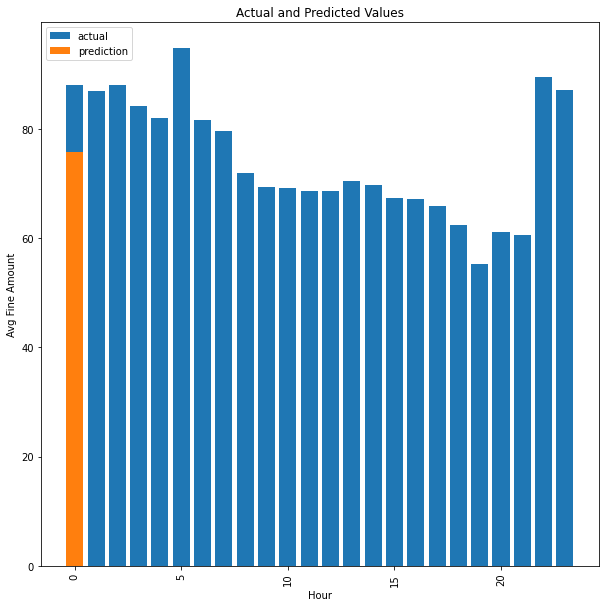

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_2_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

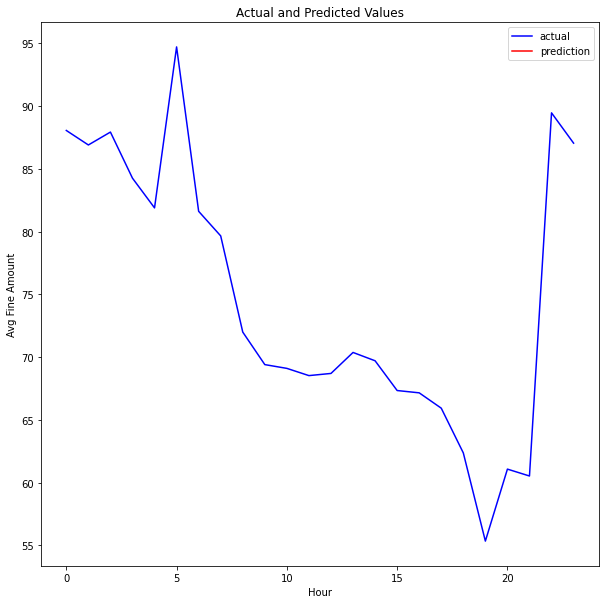

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_2_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)

## Model df_3

### df_1 Train & Valid & Test

In [ ]:
df_train = df_3
# df_valid = df_1_oh
df_test = df_3_t1

In [ ]:
#df_1
from sklearn.model_selection import train_test_split

# Train and Valid
X3 = df_train[["Violation_Hour", "Issue_Weekday", 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
# y = df_train[["count(Violation)"]]
y3 = df_train[["avg(Fine Amount)"]]
X_train, X_valid, y_train, y_valid = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [ ]:
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'month', 'day','AWND','avg(TAVG)','avg(SNWD)','avg(WT01)']]
y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12203 entries, 10978 to 15795
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Violation_Hour  12203 non-null  float32
 1   Issue_Weekday   12203 non-null  float32
 2   month           12203 non-null  float32
 3   day             12203 non-null  float32
 4   AWND            12203 non-null  float64
 5   avg(TAVG)       12203 non-null  float64
 6   avg(SNWD)       12203 non-null  float64
 7   avg(WT01)       12203 non-null  float64
dtypes: float32(4), float64(4)
memory usage: 667.4 KB


In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(12203, 8)
(12203, 1)
(5231, 8)
(5231, 1)
(1842, 8)
(1842, 1)


(None, None)

In [ ]:
y_train

,avg(Fine Amount)
10978,82.318841
5743,59.136044
2596,61.119718
13348,60.259109
573,79.692308
...,...
11284,165.000000
11964,67.420091
5390,55.989673
860,79.857143


### Model_XGBoostRegressor

In [ ]:
import os
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Time series decomposition
# pip install statsmodels==0.10.2 #!pip install stldecompose
# from stldecompose import decompose
# from .stl import decompose, forecast

# Chart drawing
# pip install plotly
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [ ]:
#%% Create XGBoost Model
reg = xgb.XGBRegressor(n_estimators=15000,learning_rate=0.12)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=1000,
       verbose=True) # Change verbose to True if you want to see it train
#Features Importance
_ = plot_importance(reg, height=0.8)

In [ ]:
#%%Forecast on Test Set
# df_test['Prediction_count'] = reg.predict(X_test)
df_test['Prediction_Fine'] = reg.predict(X_test)

# df_test['change_count'] = df_test['count(Violation)'] - df_test['Prediction_count']
df_test['change_Fine'] = df_test['avg(Fine Amount)'] - df_test['Prediction_Fine']

In [ ]:
df_test

In [ ]:
from sklearn.metrics import r2_score
# r2_score(y_true, y_pred)
# r2_score = r2_score(df_test['count(Violation)'], df_test['Prediction_count'])
r2_score = r2_score(df_test['avg(Fine Amount)'], df_test['Prediction_Fine'])
print("mean cross validation score: {}".format(r2_score))

In [ ]:
# r2_score(df_test['avg(Fine Amount)'], df_test['Prediction'])

Cross validation

In [ ]:
# import  xgboost as xgb
# # from Utils import  pathUtils
# import pandas as pd
# from sklearn.model_selection import  train_test_split
# # from Process.genBasicData import genData
# # from Utils import  feaUtils

# # train_data = genData(pathUtils.train_path)
# # test_data = genData(pathUtils.test_path)

# param = {'max_depth': 3,
#          'learning_rate ': 0.01,
#          'silent': 1,
#          'objective': 'binary:logistic',
#          "eval_metric":"auc",
#          "scale_pos_weight":10,
#          "subsample":0.8,
#          "min_child_weight":1,
#          "n_estimators": 1}

# # features = [i for i in list(train_data.columns) if i not in ["ID","y"]]
# # features = feaUtils.train_fea
# # x_train, x_valid, y_train, y_valid = train_test_split(train_data[features],train_data["y"],
# #                                                       test_size=0.2, random_state=66)

# # x_train, x_valid, y_train, y_valid = X_train, X_valid, y_train, y_valid
# # X_test y_test

# dtrain = xgb.DMatrix(X_train, y_train)
# dvalid = xgb.DMatrix(X_valid, y_valid)
# dtest  = xgb.DMatrix(X_test)


# evallist = [(dtrain,"train"),(dvalid,"valid")]
# num_round = 20000
# bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=30)


# y_pre = bst.predict(dtest, ntree_limit = bst.best_ntree_limit)

# res = pd.concat([y_test,pd.DataFrame(y_pre,columns=["pred"])],axis=1)
# # res.to_csv(pathUtils.predict_root_path+"3.csv",index=False)
# res

### DecisionTreeRegressor

In [ ]:
# df_train = df
# df_test = df2
# X_train = df_train[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_train = df_train[["avg(Fine Amount)"]] #.iloc[:, [4]] #avg(Fine Amount)
# y_train = df_train[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)

# # X_valid = df_valid[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']] #['SP500_I'].copy()
# # y_valid  = df_valid[["avg(Fine Amount)"]]
# # y_valid = df_valid[["count(Violation)"]] # .drop(['SP500_I'], 1)

# X_test  = df_test[["Violation_Hour", "Issue_Weekday", 'Kings', 'Queens', 'Bronx', 'Richmond', 'NewYork', 'Saratoga', 'Albany', 'Fulton', 'Putnam', 'month', 'day']]
# # y_test  = df_test[["avg(Fine Amount)"]] # .iloc[:, [4]] #avg(Fine Amount)
# y_test  = df_test[["count(Violation)"]] # .iloc[:, [5]] #count(Violation)


In [ ]:
# from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

### RandomForestRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, random_state=42)
X_train = X3
y_train = y3.values.ravel()
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# y_test = y_test.values.ravel()
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
# print(f'Test data R-2 score: {test_score:>5.3}')
# print(f'Test data Spearman correlation: {spearman[0]:.3}')
# print(f'Test data Pearson correlation: {pearson[0]:.3}')

In [ ]:
predicted_test = pd.DataFrame(predicted_test, columns = ['predicted_FineAmount'])
test_score = r2_score(y_test, predicted_test['predicted_FineAmount'])

print("mean cross validation score: {}".format(test_score))

In [ ]:
predicted_test

### avg dt plot

In [ ]:
df_test['Prediction_FineAmount_RF'] = predicted_test['predicted_FineAmount']

df_test['change_FineAmount_RF'] = df_test['avg(Fine Amount)'] - df_test['Prediction_FineAmount_RF']

df_test

,County,DATE,Violation_Hour,Issue_Weekday,avg(Fine Amount),count(Violation),AWND,avg(TAVG),avg(SNWD),avg(WT01),year,month,day,Prediction_FineAmount_RF,change_FineAmount_RF
0,Queens,2022-01-01,0.0,6.0,95.000000,3.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,82.151006,12.848994
1,Queens,2022-01-01,1.0,6.0,67.600000,25.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,82.110485,-14.510485
2,Queens,2022-01-01,2.0,6.0,78.095238,21.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,84.377502,-6.282264
3,Queens,2022-01-01,3.0,6.0,77.142857,28.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,79.862595,-2.719738
4,Queens,2022-01-01,4.0,6.0,65.000000,18.0,6.26,55.0,26.5,9.00,2022,1.0,1.0,85.585085,-20.585085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,Queens,2022-03-22,3.0,2.0,115.000000,1.0,16.11,54.0,25.5,30.00,2022,3.0,22.0,85.511136,29.488864
1838,Queens,2022-03-23,22.0,3.0,95.000000,1.0,11.63,46.0,22.5,23.00,2022,3.0,23.0,82.687624,12.312376
1839,Queens,2022-04-05,18.0,2.0,115.000000,1.0,7.61,52.0,24.5,19.90,2022,4.0,5.0,80.906352,34.093648
1840,Queens,2022-04-07,20.0,4.0,115.000000,1.0,16.78,52.0,24.0,25.55,2022,4.0,7.0,80.907365,34.092635


In [ ]:
dt_predictions_2=spark.createDataFrame(df_test)
dt_predictions_2.printSchema()
dt_predictions_2.show()

root
 |-- County: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- Violation_Hour: double (nullable = true)
 |-- Issue_Weekday: double (nullable = true)
 |-- avg(Fine Amount): double (nullable = true)
 |-- count(Violation): double (nullable = true)
 |-- AWND: double (nullable = true)
 |-- avg(TAVG): double (nullable = true)
 |-- avg(SNWD): double (nullable = true)
 |-- avg(WT01): double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- Prediction_FineAmount_RF: double (nullable = true)
 |-- change_FineAmount_RF: double (nullable = true)

+------+----------+--------------+-------------+------------------+----------------+----+---------+---------+---------+----+-----+---+------------------------+--------------------+
|County|      DATE|Violation_Hour|Issue_Weekday|  avg(Fine Amount)|count(Violation)|AWND|avg(TAVG)|avg(SNWD)|avg(WT01)|year|month|day|Prediction_FineAmount_RF|change_FineAmount_

#### hour

In [ ]:
data_dt_2020_1=dt_predictions_2.select("avg(Fine Amount)","Violation_Hour","Prediction_FineAmount_RF","count(Violation)")
data_dt_2020_1.show(50)

+------------------+--------------+------------------------+----------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|
+------------------+--------------+------------------------+----------------+
|              95.0|           0.0|       82.15100612948939|             3.0|
|              67.6|           1.0|       82.11048459550972|            25.0|
|  78.0952380952381|           2.0|       84.37750167846487|            21.0|
| 77.14285714285714|           3.0|       79.86259545627598|            28.0|
|              65.0|           4.0|       85.58508549564276|            18.0|
|59.285714285714285|           5.0|       99.22744624264091|            14.0|
|            71.875|           6.0|       65.03564763481764|             8.0|
|              50.0|           7.0|       69.65663739526326|            13.0|
|  67.6923076923077|           8.0|        77.9775029692518|            13.0|
| 88.94736842105263|           9.0|       78.58213179224366|    

In [ ]:
from pyspark.sql.functions import col

data_dt_2020_2=data_dt_2020_1.withColumn("total",(col("count(Violation)")*col("avg(Fine Amount)")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|
+------------------+--------------+------------------------+----------------+------------------+
|              95.0|           0.0|       82.15100612948939|             3.0|             285.0|
|              67.6|           1.0|       82.11048459550972|            25.0|1689.9999999999998|
|  78.0952380952381|           2.0|       84.37750167846487|            21.0|1640.0000000000002|
| 77.14285714285714|           3.0|       79.86259545627598|            28.0|            2160.0|
|              65.0|           4.0|       85.58508549564276|            18.0|            1170.0|
|59.285714285714285|           5.0|       99.22744624264091|            14.0|             830.0|
|            71.875|           6.0|       65.03564763481764|             8.0|             575.0|
|              50.0|          

In [ ]:
data_dt_2020_2=data_dt_2020_2.withColumn("total_prediction",(col("count(Violation)")*col("Prediction_FineAmount_RF")))
data_dt_2020_2.show()

+------------------+--------------+------------------------+----------------+------------------+------------------+
|  avg(Fine Amount)|Violation_Hour|Prediction_FineAmount_RF|count(Violation)|             total|  total_prediction|
+------------------+--------------+------------------------+----------------+------------------+------------------+
|              95.0|           0.0|       82.15100612948939|             3.0|             285.0|246.45301838846817|
|              67.6|           1.0|       82.11048459550972|            25.0|1689.9999999999998| 2052.762114887743|
|  78.0952380952381|           2.0|       84.37750167846487|            21.0|1640.0000000000002|1771.9275352477623|
| 77.14285714285714|           3.0|       79.86259545627598|            28.0|            2160.0|2236.1526727757273|
|              65.0|           4.0|       85.58508549564276|            18.0|            1170.0|1540.5315389215696|
|59.285714285714285|           5.0|       99.22744624264091|            

In [ ]:
data_dt_2020_2.dtypes

[('avg(Fine Amount)', 'double'),
 ('Violation_Hour', 'double'),
 ('Prediction_FineAmount_RF', 'double'),
 ('count(Violation)', 'double'),
 ('total', 'double'),
 ('total_prediction', 'double')]

In [ ]:
from pyspark.sql.functions import col,sum,avg,max
data_dt_2020_3=data_dt_2020_2.groupBy("Violation_Hour").agg(sum("count(Violation)").alias("sum_count"),sum("total").alias("total_amount"),sum("total_prediction").alias("total_prediction_amount"))
data_dt_2020_3.show(50)

+--------------+---------+------------+-----------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|
+--------------+---------+------------+-----------------------+
|           8.0|  64228.0|   4109214.0|      4650825.654107797|
|           0.0|   1535.0|    126075.0|     125589.79820857689|
|           7.0|  44234.0|   3102450.0|      3174300.694226349|
|          18.0|  22109.0|   1272375.0|     1909743.5617841007|
|           1.0|   4105.0|    349035.0|     301504.02700800146|
|           4.0|    892.0|     67145.0|      63331.48461431415|
|          23.0|   2246.0|    182026.0|     201153.57807823014|
|          11.0|  64263.0|   3904060.0|      4955672.790954754|
|          21.0|  23899.0|   1372080.0|     2075714.3360120123|
|          14.0|  63389.0|   3792070.0|      5260999.610892411|
|          22.0|   4357.0|    369595.0|      386250.9406247276|
|           3.0|   1801.0|    143440.0|     125526.24403200304|
|          19.0|  20355.0|   1069260.0| 

In [ ]:
data_dt_2020_4=data_dt_2020_3.withColumn("avg_prediction",(col("total_prediction_amount")/col("sum_count"))).withColumn("avg_fine",(col("total_amount")/col("sum_count")))
data_dt_2020_4.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           8.0|  64228.0|   4109214.0|      4650825.654107797|72.41118599532598| 63.97854518278633|
|           0.0|   1535.0|    126075.0|     125589.79820857689|81.81745811633674| 82.13355048859935|
|           7.0|  44234.0|   3102450.0|      3174300.694226349|71.76155659054909| 70.13722475923498|
|          18.0|  22109.0|   1272375.0|     1909743.5617841007|86.37855903858613|57.550092722420736|
|           1.0|   4105.0|    349035.0|     301504.02700800146|73.44799683507952| 85.02679658952496|
|           4.0|    892.0|     67145.0|      63331.48461431415|70.99942221335667| 75.27466367713005|
|          23.0|   2246.0|    182026.0|     201153.57807823014|89.56080947383354| 81.044523

In [ ]:
data_dt_2020_5=data_dt_2020_4.sort(data_dt_2020_4.Violation_Hour.asc())
data_dt_2020_5.show()

+--------------+---------+------------+-----------------------+-----------------+------------------+
|Violation_Hour|sum_count|total_amount|total_prediction_amount|   avg_prediction|          avg_fine|
+--------------+---------+------------+-----------------------+-----------------+------------------+
|           0.0|   1535.0|    126075.0|     125589.79820857689|81.81745811633674| 82.13355048859935|
|           1.0|   4105.0|    349035.0|     301504.02700800146|73.44799683507952| 85.02679658952496|
|           2.0|   3597.0|    308185.0|     247769.78193742008|68.88234137820965| 85.67834306366416|
|           3.0|   1801.0|    143440.0|     125526.24403200304|  69.698081083844|  79.6446418656302|
|           4.0|    892.0|     67145.0|      63331.48461431415|70.99942221335667| 75.27466367713005|
|           5.0|   5350.0|    497225.0|     373334.74112443975|69.78219460269902|  92.9392523364486|
|           6.0|  34072.0|   2631680.0|     2408761.7060383875|70.69622288208463| 77.238788

In [ ]:
dff_dt_2020=data_dt_2020_5.toPandas()
print(dff_dt_2020)

    Violation_Hour  sum_count  total_amount  total_prediction_amount  \
0              0.0     1535.0      126075.0             1.255898e+05   
1              1.0     4105.0      349035.0             3.015040e+05   
2              2.0     3597.0      308185.0             2.477698e+05   
3              3.0     1801.0      143440.0             1.255262e+05   
4              4.0      892.0       67145.0             6.333148e+04   
5              5.0     5350.0      497225.0             3.733347e+05   
6              6.0    34072.0     2631680.0             2.408762e+06   
7              7.0    44234.0     3102450.0             3.174301e+06   
8              8.0    64228.0     4109214.0             4.650826e+06   
9              9.0    64000.0     3860050.0             4.621149e+06   
10            10.0    61343.0     3707458.0             4.509691e+06   
11            11.0    64263.0     3904060.0             4.955673e+06   
12            12.0    62452.0     3678145.0             4.923386

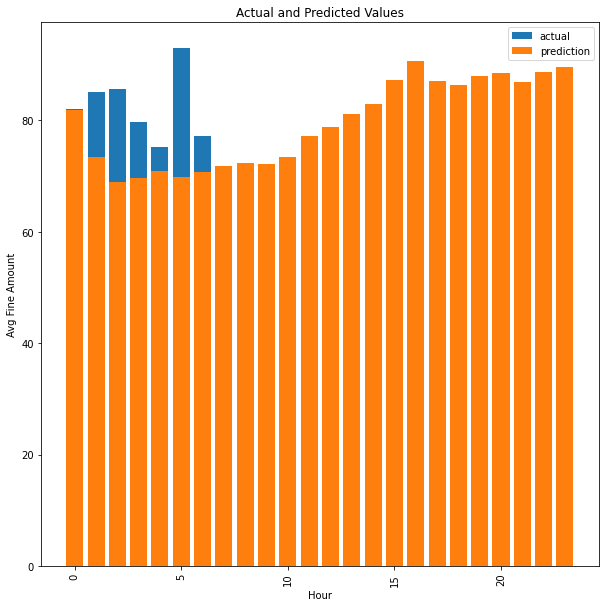

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], label = 'actual')
# Plot the predicted values
plt.bar(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], label = 'prediction')
plt.xticks(rotation = '90')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_3_RF_FineAmount_hour.png'
plt.savefig(path+filenames, dpi=300)

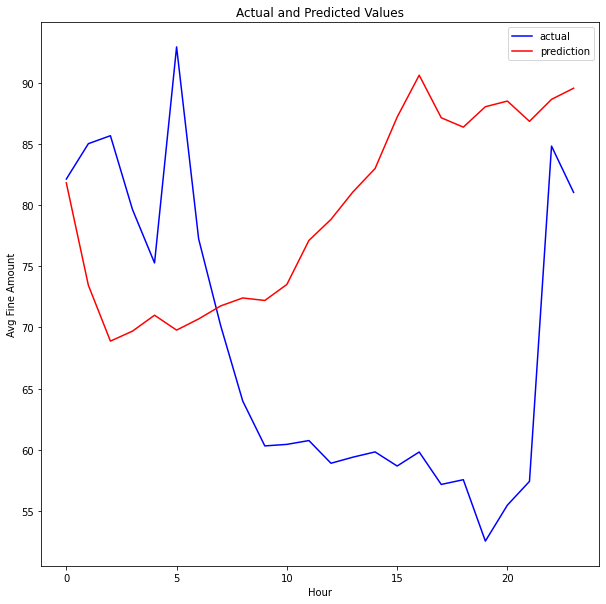

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Plot the actual values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_fine'], 'b',label = 'actual')
# Plot the predicted values
plt.plot(dff_dt_2020['Violation_Hour'], dff_dt_2020['avg_prediction'], 'r', label = 'prediction')
#plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Hour')
plt.ylabel('Avg Fine Amount')
plt.title('Actual and Predicted Values')
# plt.savefig("/content/drive/MyDrive/0_ Big Data _ Group Project Note/01_Dataset/Avg_Fine_Amount.png")

path = '/content/drive/MyDrive/01_GMBA/2nd_semester(2022)/03-1AM_Big Data Analytics Techniques and Applications/0_ Big Data _ Group Project/0_ Big Data _ Group Project Note/03_Pic/01_ML_Pic/FineAmount/Test2022/'
filenames = 'Test2022_df_3_RF_FineAmount_hour_line.png'
plt.savefig(path+filenames, dpi=300)